# Project - Natural Language Processing - 1
## by HARI SAMYNAATH S

## Part ONE

**DOMAIN:** Digital content management<br>
**• CONTEXT:** Classification is probably the most popular task that you would deal with in real life. Text in the form of blogs, posts, articles, etc. is written every second. It is a challenge to predict the information about the writer without knowing about him/her. We are going to create a classifier that predicts multiple features of the author of a given text. We have designed it as a Multi label classification problem.<br>
**• DATA DESCRIPTION:** Over 600,000 posts from more than 19 thousand bloggers The Blog Authorship Corpus consists of the collected posts of 19,320 bloggers gathered from blogger.com in August 2004. The corpus incorporates a total of 681,288 posts and over 140 million words - or approximately 35 posts and 7250 words per person. Each blog is presented as a separate file, the name of which indicates a blogger id# and the blogger’s self-provided gender, age, industry, and astrological sign. (All are labelled for gender and age but for many, industry and/or sign is marked as unknown.) All bloggers included in the corpus fall into one of three age groups:<br>
• 8240 "10s" blogs (ages 13-17),<br>
• 8086 "20s" blogs(ages 23-27) and<br>
• 2994 "30s" blogs (ages 33-47)<br>
For each age group, there is an equal number of male and female bloggers. Each blog in the corpus includes at least 200 occurrences of common English words. All formatting has been stripped with two exceptions. Individual posts within a single blogger are separated by the date of the following post and links within a post are denoted by the label url link. Link to dataset: https://www.kaggle.com/rtatman/blog-authorship-corpus<br>
**• PROJECT OBJECTIVE:** The need is to build a NLP classi ier which can use input text parameters to determine the label/s of the blog.<br>

In [1]:
def libraries():
    
    global pd,np,Parallel,delayed,tqdm,time,pickle,metrics,plt,sns,datetime,os
    global tf, Dense, Embedding, Input, Add, Dot, Reshape, Flatten, Conv2D, Concatenate
    global K, Model, load_model, plot_model, optimizers, regularizers, hp, BatchNormalization
    global Conv1D, ZeroPadding1D, MaxPooling1D, GlobalMaxPool1D, Activation, Dropout, Lambda
    global re,emoji,nltk,html,num2words,punctuation,stopwords
    global WordNetLemmatizer, word_tokenize,pos_tag, skipgrams, Tokenizer

    # basics
    import pandas as pd
    import numpy as np
    from joblib import Parallel, delayed
    from tqdm import tqdm
    import time, pickle
    import datetime, os
    
    # metrics
    from sklearn import metrics

    # visualizations
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # neural network libraries for NLP
    import tensorflow as tf
    from tensorflow.keras.layers import Dense, Embedding, Input, Add, Dot, Reshape, Flatten, Conv2D, Concatenate
    from tensorflow.python.keras import backend as K
    from tensorflow.keras.models import Model, load_model
    from tensorflow.keras.utils import plot_model
    from tensorflow.keras import optimizers, regularizers
    from tensorboard.plugins.hparams import api as hp 
    from tensorflow.keras.layers import Dense, BatchNormalization, Input, Dropout, Lambda
    from tensorflow.keras.layers import Conv1D, ZeroPadding1D, MaxPooling1D, GlobalMaxPool1D, Activation

    
    # NLP libraries
    import re, emoji, nltk, html
    from num2words import num2words
    from string import punctuation
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    from nltk import word_tokenize, pos_tag  
    from tensorflow.keras.preprocessing.sequence import skipgrams
    from tensorflow.keras.preprocessing.text import Tokenizer
    
libraries()
pd.set_option('display.max_columns', 50)

## user defined methods & classes

In [2]:
# build TF-IDF vector
class tfIdfVectorizer():
    """compute Tf-Idf for documents based on a corpus"""
    def __init__(self,corpus):
        """fit on tokenized corpus"""
        
        # create the vocabulary
        self.vocabulary = set(['not_in_here']) # with null word
        for doc in tqdm(corpus,desc="update vocabulary"): self.vocabulary.update(doc);
            
        self.w2id = {w: index for index, w in enumerate(self.vocabulary)}
        
        # count of documents using each word
        self.word_doc_count = np.zeros(len(self.vocabulary),dtype='uint32')
        for doc in tqdm(corpus, desc="word_doc_count"):
            for word in set(doc):
                self.word_doc_count[self.w2id.get(word,0)]+=1
                
        # inverse document frequency
        self.wIDF = np.log( len(corpus) / (1+ self.word_doc_count).astype(float))
        
        self.fitted=False
    
    def tfidfVector(self,doc):
        tmp = np.zeros(50,dtype=float)
        vec = np.array([float(doc.tolist().count(word)) * self.wIDF[self.w2id.get(word,0)] / len(doc)
                        for word in doc], dtype=float)
        tmp[:len(vec)] = vec
        return tmp
    
    def minMax(self,array): return (min(array),max(array))
    def scaler(self,array): return (array - self.minTFIDF)/(self.maxTFIDF-self.minTFIDF)
    
    def fit(self,corpus):
        self.minTFIDF = 0
        self.maxTFIDF = 0
        for doc in tqdm(corpus,desc="TfIdf_fit"):
            (mi,ma)=self.minMax(self.tfidfVector(doc))
            self.minTFIDF = min(self.minTFIDF,mi)
            self.maxTFIDF = max(self.maxTFIDF,ma)
        selt.fitted = True
            
    def fit_transform(self,corpus):
        vector = []
        for doc in tqdm(corpus,desc="TfIdf_fit_transform"):
            vec = self.tfidfVector(doc)
            vector.append(vec)
        
        self.minTFIDF = min(map(min,vector))
        self.maxTFIDF = max(map(max,vector))    
        # minmax scaling
        vector = list(map(self.scaler,vector))
        
        self.fitted=True
        return vector
    
    def transform(self,newcorpus):
        if not self.fitted:
            raise Exception("please fit on a corpus before transforming")
        
        vector = []
        for doc in tqdm(newcorpus,desc="TfIdf_transform"):
            vector.append(self.scaler(self.tfidfVector(doc)))
        return vector       

In [3]:
class preprocess():
    """perform all preparatory actions on the dataset"""
    def __init__(self):
        
        # label encode POS tags (independant of train test split)
        # tags list
        self.TagMaster = np.array(['not_in_here','(',')','$',',','--','.',':','CC','CD','DT','EX','FW','IN','JJ',
                              'JJR','JJS','LS','MD','NN','NNP','NNPS','NNS','PDT','POS','PRP','PRP$','RB',
                              'RBR','RBS','RP','SYM','TO','UH', 'VB','VBD','VBG','VBN','VBP','VBZ','WDT',
                              'WP','WP$','WRB','``'])
        # tags index
        self.tag2id = {t: index for index, t in enumerate(self.TagMaster)}
        
        # references
        self.miWi = self.maWi = self.miWj = self.maWj = 0
        
        # output organising
        # gender binary class
        self.genders = ['female','male']
        self.g2id = dict(zip(self.genders,[0,1]))
        self.id2g = dict(zip([0,1],self.genders))

        # age continuous regression output

        # topics as categories
        self.topics = np.append(['not_in_here'],np.sort(df["topic"].unique()))
        self.t2id = dict(zip(self.topics,range(len(self.topics))))
        self.id2t = dict(zip(range(len(self.topics)),self.topics))

        # Astrological signs in order of Ecliptic Longitude
        self.signs = ['Aries','Taurus','Gemini','Cancer','Leo','Virgo',
                      'Libra','Scorpio','Sagittarius','Capricorn','Aquarius','Pisces']
        self.s2id = dict(zip(self.signs,range(len(self.signs))))
        self.id2s = dict(zip(range(len(self.signs)),self.signs))
        
        self.fitted = False

In [4]:
# prerequisites
sWords = stopwords.words('english') + list(punctuation)
lemma = WordNetLemmatizer().lemmatize

lemmaPOS = {p:'v' for p in ['VB','VBD','VBG','VBN','VBP','VBZ']}
lemmaPOS.update({p:'a' for p in ['JJ','JJR','JJS']})
lemmaPOS.update({p:'r' for p in ['RB','RBR','RBS']})
        
def wordy(doc):
    """parse & process each document"""
    
    # convert all html escape characters
    doc = html.unescape(doc)
    
    # demojize:convert emojies to word expressions & return 
    doc = emoji.demojize(doc,delimiters=(" "," "))
    
    # convert numbers to words
    for match in re.findall(r'([0-9]+[\.]{0,1}[0-9])|([0-9])',doc):
        match = np.sort(np.array(match))[-1]
        doc = re.sub(match,' '+num2words(match)+' ',doc)
        
    # remove any remaining non-alphabets
    doc = re.sub(r'[^a-zA-Z\s]','',doc)
    
    # tokenize
    # POS tagging
    wordTags = pos_tag(word_tokenize(doc))
    
    # ignore stop words
    # cast to lowercase
    # lemmatize
    wordTags = np.array([(lemma(word.lower(),lemmaPOS.get(tag,'n')),tag) 
                         for (word,tag) in wordTags if word.lower() not in sWords])
    
    return wordTags

# retained method outside class definition to enable serialisation for Parallel processing

In [5]:
def trim50(self,row):
    # generator for 50 words each from the given list of words
    # if a document is having less than 50 words, repeat the content to fill 50 counts
    # process row-wise
    words = row["words"]
    tags = row["tags"]
    for i in range(0,len(words),50):
        w = words[i:i+50]
        t = tags[i:i+50]
        if len(w) < 50:
            ntimes = int(np.ceil(50/len(w)))
            w = np.array(list(w)*ntimes)
            w = w[:50]
            t = np.array(list(t)*ntimes)
            t = t[:50]
        
        yield [w,t,row["gender"],row["age"],row["topic"],row["sign"]]
        
preprocess.trim50 = trim50

In [6]:
def tagVector(self,tags):
    tmp = np.zeros(50,dtype=float)
    # vectorize # min_max_scale
    vec = np.array([self.tag2id.get(tag,0) for tag in tags],dtype=float)/len(self.TagMaster)
    tmp[:len(vec)] = vec # pad trailing zeros
    return tmp

preprocess.tagVector = tagVector

In [7]:
def prefit(self,df):
    
    # strip all spaces on either edges of the text field
    tqdm.pandas(desc="strip")
    df["text"] = df["text"].progress_apply(lambda x: x.strip())
    
    # demojize,num2words,strip-non-alphabets,tokenize
    textArray = df.text.values
    df["wordTags"] = Parallel(n_jobs=-1,verbose=0)(delayed(wordy)(doc) for doc in tqdm(textArray,desc="wordy"))
    
    # separate words & tags
    tqdm.pandas(desc="word Separation")
    df["words"] = df["wordTags"].progress_apply(lambda x: np.array([w for (w,t) in x]))
    tqdm.pandas(desc="tag Separation")
    df["tags"] = df["wordTags"].progress_apply(lambda x: np.array([t for (w,t) in x]))
    
    # drop records whose words were only stop words
    tqdm.pandas(desc="empties deletion")
    df.drop(df.loc[df.words.progress_apply(lambda x: len(x))==0].index,inplace=True)
    
    # trim & stack @50 words length each
    cols = ["words","tags","gender","age","topic","sign"]
    df2 = pd.DataFrame(columns=cols)
    for i in tqdm(df.index,desc="trim@50"):
        df2 = df2.append(pd.DataFrame(self.trim50(df.loc[i]),columns=cols))
    df = df2
    
    # transform tags
    tqdm.pandas(desc="tag vectorization")
    df["tags"] = df["tags"].progress_apply(lambda x:self.tagVector(x))
    
    # reset index
    df.reset_index(drop=True,inplace=True)
    
    return df

preprocess.prefit = prefit

In [8]:
# build word-word co-occurance matrix
def coOccurance(self,corpus,window):
    self.co_mat = np.zeros((len(self.vocab),len(self.vocab)),dtype='float16')
    for doc in tqdm(corpus,desc="co-occurance_matrix"):
        for i in range(len(doc)):
            wi_lower = max((0,i-window))
            wi_upper = min(len(doc),i+window)
            for j in range(wi_lower,wi_upper):
                # increment the positions of the skipgrams, normalised to distance from subject word
                self.co_mat[self.w2id.get(doc[i],0),self.w2id.get(doc[j],0)] += (0.0 if j==i else abs(1/(j-i)))

preprocess.coOccurance = coOccurance

In [9]:
def WiWj(self,doc):
    # sequence of word indexes
    sequence = [self.w2id.get(word,0) for word in doc]
    # skipgram of the sequence
    wordSets,_ = skipgrams(sequence,vocabulary_size=len(self.vocab)+1,window_size=4,
                           negative_samples=0,shuffle=False)
    if len(wordSets)==0:
        Wi = Wj = np.zeros((1,380),dtype=int)
    else:
        # pair reorder
        Wi,Wj = zip(*wordSets)
        Wi,Wj = np.array(Wi).reshape(1,-1),np.array(Wj).reshape(1,-1)
    Ti = np.zeros((1,380),dtype=int)
    Tj = np.zeros((1,380),dtype=int)
    Ti[0,:Wi.shape[-1]] = Wi[0]
    Tj[0,:Wj.shape[-1]] = Wj[0]
    
    return np.array([Ti,Tj])

preprocess.WiWj = WiWj

In [10]:
def X_ij(self,wPair):
    Wi,Wj = wPair
    Xij = self.co_mat[Wi[0,:],Wj[0,:]].reshape(1,-1)+1    
    return Xij

preprocess.X_ij = X_ij

In [11]:
def topicEncode(self,topic):
    tvec = np.zeros(len(self.topics),dtype=float)
    tvec[self.t2id.get(topic,0)] = 1
    return tvec

preprocess.topicEncode = topicEncode

In [12]:
def gloveComponents(self,df):
    # word sequences & skipgram
    tqdm.pandas(desc="skipGram")
    df["WiWj"] = df["words"].progress_apply(lambda doc: self.WiWj(doc))
    # co-occurance vector
    tqdm.pandas(desc="co-occurance_vector")
    df["Xij"] = df["WiWj"].progress_apply(lambda wPair: self.X_ij(wPair))
    # word pair separation
    tqdm.pandas(desc="wPair_separation1")
    df["Wi"] = df["WiWj"].progress_apply(lambda x: x[0])
    tqdm.pandas(desc="wPair_separation2")
    df["Wj"] = df["WiWj"].progress_apply(lambda x: x[1])
    df.drop(["WiWj"],axis=1,inplace=True)
    
    return df

preprocess.gloveComponents = gloveComponents

In [13]:
def postfit(self,df):
    
    # minmax scaling
    tqdm.pandas(desc="Wi_scaling")
    df["Wi"] = df["Wi"].progress_apply(lambda x: np.array((x - self.miWi)/(self.maWi-self.miWi),dtype=float))
    tqdm.pandas(desc="Wj_scaling")
    df["Wj"] = df["Wj"].progress_apply(lambda x: np.array((x - self.miWj)/(self.maWj-self.miWj),dtype=float))
    tqdm.pandas(desc="Xij_scaling")
    df["Xij"] = df["Xij"].progress_apply(lambda x: np.array(((x - self.miXij)
                                                             /(self.maXij-self.miXij))+1e-7,dtype=float))
    
    # target features processing
    tqdm.pandas(desc="genderEncoding")
    df["gender"] = df["gender"].progress_apply(lambda x: 0 if x=='female' else 1)
    tqdm.pandas(desc="topicEncoding")
    df["topic"] = df["topic"].progress_apply(lambda x: self.topicEncode(x))
    tqdm.pandas(desc="signEncoding")
    df["sign"] = df["sign"].progress_apply(lambda x: self.s2id.get(x)/len(self.signs))
    tqdm.pandas(desc="ageScaling")
    df["age"] = df["age"].progress_apply(lambda x: (x-self.miAge)/(self.maAge-self.miAge))
    
    return df

preprocess.postfit = postfit

In [14]:
def outVectors(self,df):
    # vectors for the network
    tags = np.empty((len(df),50),dtype=float)
    tfidf = np.empty((len(df),50),dtype=float)
    lEncd = np.empty((len(df),50),dtype=float)
    Wi = np.empty((len(df),380),dtype=float)
    Wj = np.empty((len(df),380),dtype=float)
    Xij = np.empty((len(df),380),dtype=float)
    gender = np.empty((len(df),1),dtype=float)
    age = np.empty((len(df),1),dtype=float)
    topic = np.empty((len(df),40),dtype=float)
    sign = np.empty((len(df),1),dtype=float)
    for i in tqdm(range(len(df)),desc="final vectors"):
        tags[i,:] = df.tags[i]
        tfidf[i,:] = df.tfidf[i]
        lEncd[i,:] = df.lEncd[i]
        Wi[i,:] = df.Wi[i][0]
        Wj[i,:] = df.Wj[i][0]
        Xij[i,:] = df.Xij[i][0]
        gender[i,0] = df.gender[i]
        age[i,0] = df.age[i]
        topic[i,:] = df.topic[i]
        sign[i,:] = df.sign[i]
    return [Wi,Wj,Xij,tags,tfidf,lEncd],[gender,age,topic,sign]

preprocess.outVectors = outVectors

In [15]:
def transform(self,df):
    df = df.copy()
    if not self.fitted:
        raise Exception("please fit on a training data")
    # basic preprocessing
    df = self.prefit(df)
    # TF-IDF vectorization
    df["tfidf"] = self.tfidf.transform(df.words)    
    # labelEncoding
    tqdm.pandas(desc="LabelEncoding")
    nVocab = float(len(self.vocab))
    df["lEncd"] = df["words"].progress_apply(lambda doc: [self.w2id.get(word,0)/nVocab for word in doc])
    # in-out for GloVe
    df = self.gloveComponents(df)
    # scaling & encoding
    df = self.postfit(df) 
    
    return self.outVectors(df)

preprocess.transform = transform

In [16]:
def fit_transform(self,df):
    df = df.copy()
    
    # basic preprocessing
    df = self.prefit(df)
    
    # TF-IDF vectorization
    self.tfidf = tfIdfVectorizer(df.words)
    df["tfidf"] = self.tfidf.fit_transform(df.words)
    # Vocabulary details
    self.vocab = self.tfidf.vocabulary
    self.w2id = self.tfidf.w2id
    # labelEncoding
    tqdm.pandas(desc="LabelEncoding")
    nVocab = float(len(self.vocab))
    df["lEncd"] = df["words"].progress_apply(lambda doc: [self.w2id.get(word,0)/nVocab for word in doc])
    # Co-occurance matrix
    self.coOccurance(df["words"],4)
    # in-out for GloVe
    df = self.gloveComponents(df)
    
    # scaling references
    self.miWi = min(map(np.min,df.Wi))
    self.maWi = max(map(np.max,df.Wi))
    self.miWj = min(map(np.min,df.Wj))
    self.maWj = max(map(np.max,df.Wj))
    self.miXij = min(map(np.min,df.Xij))
    self.maXij = max(map(np.max,df.Xij))
    self.miAge = df.age.min()
    self.maAge = df.age.max()
    
    # scaling & encoding
    df = self.postfit(df) 
        
    self.fitted = True
    
    return self.outVectors(df)

preprocess.fit_transform = fit_transform

In [17]:
# customised learning rate scheduler
# considering slope of validation loss
class lossGradientLR(tf.keras.callbacks.Callback):
    """gradually descend learning rate if the loss defined my the model is not descending at desired rate"""
    def __init__(self,initial_learning_rate=1e-3,patience=5,
                 slope=0.25,factor=0.75,lr_least=1e-10,verbose=False):
        super(lossGradientLR, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.patience = patience
        self.slope = -slope
        self.factor = factor
        self.lr_least = lr_least
        self.verbose = verbose
        self.loss = []
        self.lr = [initial_learning_rate]
        self.lastAdjust = 0
        
    def Gradient_schedule(self,epoch):
        """scheduled learning rate manipulation"""
        flag1 = False
        flag1 = (epoch-self.lastAdjust)>self.patience # min epoch before adjust
        
        flag2 = False
        try:
            flag2 = (self.loss[-1]-self.loss[-2])>0 and (self.loss[-2]-self.loss[-3])>0
            # if two continuous epochs have increasing validation loss
        except:
            pass
        
        # slope of validation loss
        lossGrad = (self.loss[-1]-self.loss[self.lastAdjust])
        lossGrad/= len(self.loss[self.lastAdjust:])
        
        # if slope of validation loss not descending at slope or flag2
        if (flag1 and lossGrad>self.slope) or (flag2):
            self.lr.append(max(self.lr[-1]*self.factor,self.lr_least)) #min lr_least
            self.lastAdjust = epoch # update last adjust epoch
        
        if self.verbose:
            print("\n\nslopeOfLoss:%.2f"%lossGrad," @ epoch:%d"%epoch, "---- learning_rate:",self.lr[-1],"\n")
        
    def on_epoch_end(self,epoch,logs={}):
        """on end of each epoch"""
        # fetch validation loss
        self.loss.append(logs.get('val_loss'))
        #invoke learning rate calculator
        self.Gradient_schedule(epoch)
        
    def on_epoch_begin(self,epoch,logs={}):
        """beginning of each epoch"""
        # update model learning rate
        K.set_value(self.model.optimizer.lr, self.lr[-1])
        
# report learning rate to tensorboard
# due to custom lr_scheduler
class LRTensorBoard(tf.keras.callbacks.TensorBoard):
    """report to tensorfboard about the updates created by lossGradientLR"""
    def __init__(self, log_dir, **kwargs):
        super().__init__(log_dir=log_dir, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs.update({'learning_rate': K.eval(self.model.optimizer.learning_rate)})
        super().on_epoch_end(epoch, logs)

**Steps and tasks:**<br>
1. Import and analyse the data set.

In [2]:
df = pd.read_csv("blogtext.csv")
df.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [3]:
df.shape

(681284, 7)

In [4]:
df.isnull().sum() # check for null values

id        0
gender    0
age       0
topic     0
sign      0
date      0
text      0
dtype: int64

In [5]:
df.nunique() # check for unique values

id         19320
gender         2
age           26
topic         40
sign          12
date        2616
text      611652
dtype: int64

there are only 611652 unique text documents, meaning 69632 duplicate records, lets confirm the same

In [6]:
df[["text"]].duplicated().sum() # duplicate texts

69632

In [7]:
df[["id","text"]].duplicated().sum() # duplicate per blogger

6946

In [8]:
df.duplicated().sum() # overall duplicates

4686

In [9]:
df.loc[df["text"]==df.loc[df[["id","text"]].duplicated(),"text"].values[10]] # random duplicate review

,id,gender,age,topic,sign,date,text
3828,3543234,male,14,indUnk,Scorpio,"07,June,2004",ZmX: I hate these geek 20 year olds...
3829,3543234,male,14,indUnk,Scorpio,"07,June,2004",ZmX: I hate these geek 20 year olds...
418695,3546185,male,14,Technology,Sagittarius,"07,June,2004",ZmX: I hate these geek 20 year olds...
418696,3546185,male,14,Technology,Sagittarius,"07,June,2004",ZmX: I hate these geek 20 year olds...
599448,3535546,male,14,indUnk,Sagittarius,"07,June,2004",ZmX: I hate these geek 20 year olds...
599449,3535546,male,14,indUnk,Sagittarius,"07,June,2004",ZmX: I hate these geek 20 year olds...


In [10]:
df.drop(df.loc[df.duplicated()].index)[["id","text"]].duplicated().sum() 
# overall duplicates dropped, review duplicate per blogger

2260

In [11]:
df.drop(df.loc[df.duplicated()].index)[["id","date","text"]].duplicated().sum() 
# overall duplicates dropped, review duplicate per blogger on the same date

0

In [12]:
df2 = df.drop(df.loc[df.duplicated()].index)
df2.loc[df2["text"]==np.sort(df2.loc[df2[["id","text"]].duplicated(),"text"].values)[-5]] # random duplicate review

,id,gender,age,topic,sign,date,text
332145,2560114,male,17,Student,Pisces,"06,July,2004",Yo ppl...well today i was suppose to go to ...
332146,2560114,male,17,Student,Pisces,"04,July,2004",Yo ppl...well today i was suppose to go to ...


In [13]:
np.sort(df2.loc[df2[["id","text"]].duplicated(),"text"].values) # duplicate texts review

array(['    ', '    ', '    ', ...,
       '   i just cant figure why when someone does something which i find it cool.. ill try my own version.. or ist just human instinct? well.... thats for me to figure it out.... well today went right... slept the whole day.. fucking fuckingly bored.... so yea.... landed my kiickflip on holding on a rail.. but at night lost it.. then got it back after 10 20 tries... i cant see what the fucks my front foot doing.. isit flicking? or kicking? just cant see... ill just try it out at the park where the guys can see and can tell me.... hm... starting school tomoro.... hate the fuckers there.... besides the band guys....geesh... just cant wait for evertything to happen again or something.... just fuck it man.. FUCK IT!... pardon the sensorness......  ',
       "   its more eventful than mine! lol wow, *someone* cough....wrote a poem! actually wrote a poem....personally i had no clue that person could write that well. It was pretty. Especially because that

the 4686 duplicate records of the complete dataset needs to be droppped without further considerations<br>
the rest of the dupliates needs to be retained as the blogger might have share same expressions in a later date<br>

the text needs to be filtered for blank space texts

In [14]:
for match in re.finditer(r'\s{2,1000000}',df.text[16398]): # random reivew of white space >2
    print(match)

<re.Match object; span=(0, 15), match='               '>
<re.Match object; span=(49, 53), match='    '>
<re.Match object; span=(128, 131), match='   '>
<re.Match object; span=(277, 280), match='   '>
<re.Match object; span=(317, 319), match='  '>
<re.Match object; span=(322, 324), match='  '>
<re.Match object; span=(337, 346), match='         '>


In [15]:
# review all other unique values
for col in ["gender","age","topic","sign"]:
    print(col,":",np.sort(df[col].unique()))

gender : ['female' 'male']
age : [13 14 15 16 17 23 24 25 26 27 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48]
topic : ['Accounting' 'Advertising' 'Agriculture' 'Architecture' 'Arts'
 'Automotive' 'Banking' 'Biotech' 'BusinessServices' 'Chemicals'
 'Communications-Media' 'Construction' 'Consulting' 'Education'
 'Engineering' 'Environment' 'Fashion' 'Government' 'HumanResources'
 'Internet' 'InvestmentBanking' 'Law' 'LawEnforcement-Security'
 'Manufacturing' 'Maritime' 'Marketing' 'Military' 'Museums-Libraries'
 'Non-Profit' 'Publishing' 'RealEstate' 'Religion' 'Science'
 'Sports-Recreation' 'Student' 'Technology' 'Telecommunications' 'Tourism'
 'Transportation' 'indUnk']
sign : ['Aquarius' 'Aries' 'Cancer' 'Capricorn' 'Gemini' 'Leo' 'Libra' 'Pisces'
 'Sagittarius' 'Scorpio' 'Taurus' 'Virgo']


In [16]:
# number of records with IndustryUnknown
len(df.loc[df["topic"]=="indUnk"])

251015

**Steps and tasks:**<br>
2. Perform data pre-processing on the data:<br>
• Data cleansing by removing unwanted characters, spaces, stop words etc. Convert text to lowercase.<br>
• Target/label merger and transformation<br>
• Train and test split<br>
• Vectorisation, etc.<br>

In [17]:
# drop all-duplicates
df.drop(df.loc[df.duplicated()].index,inplace=True)
# drop indUnk
df.drop(df.loc[df["topic"]=="indUnk"].index,inplace=True)
# drop any blank text records
df.drop(df.loc[df["text"]==''].index,inplace=True)

In [18]:
# review output shape
df.shape

(427860, 7)

In [19]:
# train & test split 10:1 ratio
# limitting to 10000 records considering limited computational resources
np.random.seed(129)
indices = np.random.choice(range(df.shape[0]),11000,False)

dTrain = df.iloc[indices[:10000]].copy()
dTest = df.iloc[indices[10000:]].copy()

In [20]:
# review the shapes
dTrain.shape,dTest.shape

((10000, 7), (1000, 7))

In [48]:
pp = preprocess()

In [49]:
# [Wi,Wj,Xij,tags,tfidf,lEncd],[gender,age,topic,sign]

In [50]:
Xtrain,Ytrain = pp.fit_transform(dTrain)

final vectors: 100%|███████████████████| 27198/27198 [00:01<00:00, 14431.20it/s]


In [51]:
Xtest,Ytest = pp.transform(dTest)

final vectors: 100%|█████████████████████| 2616/2616 [00:00<00:00, 14097.47it/s]


In [52]:
# constituent vectors
[Wi,Wj,Xij,tags,tfidf,lEncd],[gender,age,topic,sign] = Xtrain,Ytrain
[Wiv,Wjv,Xijv,tagsv,tfidfv,lEncdv],[genderv,agev,topicv,signv] = Xtest,Ytest

In [53]:
Xval = [Wiv[:500],Wjv[:500],Xijv[:500],tagsv[:500],tfidfv[:500],lEncdv[:500]]
Yval = [genderv[:500],agev[:500],topicv[:500],signv[:500]]
Xprod = [Wiv[500:],Wjv[500:],Xijv[500:],tagsv[500:],tfidfv[500:],lEncdv[500:]]
Yprod = [genderv[500:],agev[500:],topicv[500:],signv[500:]]

In [54]:
# len of vocabulary used
nVocab = len(pp.vocab)
print(nVocab)

70354


In [45]:
# save preprocessed data to disk
file = open('XY.har','wb')
pickle.dump([Xtrain,Ytrain,Xval,Yval,Xprod,Yprod],file)
file.close()
file = open('ETL.har','wb')
pickle.dump([pp.id2s,pp.id2t,pp.s2id,pp.t2id,pp.miAge,pp.maAge,pp.vocab],file)
file.close()

In [20]:
# read from disk
file = open('XY.har','rb')
[Xtrain,Ytrain,Xval,Yval,Xprod,Yprod] = pickle.load(file)
file.close()
pp = preprocess()
file = open('ETL.har','rb')
[pp.id2s,pp.id2t,pp.s2id,pp.t2id,pp.miAge,pp.maAge,pp.vocab] = pickle.load(file)
file.close()
nVocab = len(pp.vocab)

In [21]:
def hNetTrain(modelFunc,mNamePrefix,gIndex,gridPoint,fitparams,logFile,logDir,htune=False,verbose=0,weights=None):
    
    # Random consistency seed
    np.random.seed(129)
    tf.random.set_seed(129)
    
    # create model
    model = modelFunc(gridPoint)
    
    global pGrid
    
    mname = mNamePrefix + "_%03d_"%(gIndex) + datetime.datetime.now().strftime("%d%b_%I%M%P")
    
    # create tensorboard logs & callbacks
    log_dir = os.path.join(logDir, mname)
    tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1, embeddings_freq=1)
    
    # initiate learning rate reporter
    lReport = LRTensorBoard(log_dir)
        
    # learnin rate decay scheduler
    lr = gridPoint['learningRate']
    lr_schedule = lossGradientLR(lr,factor=0.1,verbose=bool(verbose))
    
    # callback to report hyperparameters to tensorboard
    hypertune = hp.KerasCallback(log_dir,gridPoint)
    
    # collect callbacks
    cbs = [tensorboard_cb,lr_schedule,lReport]
    if htune: cbs.append(hypertune)
    
    # update fitparams
    fitparams.update(dict(callbacks=cbs,verbose=verbose))
    
    if weights!=None:
        model.load_weights(weights)
    
    # model fitting
    with tf.device('/device:GPU:0'):
        logger = model.fit(**fitparams)
        
    # summarise hyperparametters with results
    if htune:
        with tf.summary.create_file_writer(logDir +'/hparam_tuning').as_default():
            hp.hparams(gridPoint)
        
        # record result to pGrid
        pGrid.loc[gIndex,'epoch'] = len(logger.history.get('loss'))
        for key in logger.history.keys():
            pGrid.loc[gIndex,key] = logger.history.get(key)[-1]
    
    return model

In [20]:
def nlpNet(gridPoint):
    
    nStartChnls = int(gridPoint["nStartChnls"])
    fSize = int(gridPoint["fSize"])
    dOutR = gridPoint["dOutR"]
    lmbda = gridPoint["lmbda"]
    embSize = int(gridPoint["embSize"])
    lr = gridPoint['learningRate']
    lWeight = bool(gridPoint['lWeight'])
    
    DTYPE = float    
    global nVocab
    
    # Random consistency seed
    np.random.seed(129)
    tf.random.set_seed(129)
    
    # 50 len vectors
    I_tags = Input(shape=(50),name='tags')    # POS Tags
    I_tfidf = Input(shape=(50),name='tfidf')  # TF-IDF Vector
    I_lEncd = Input(shape=(50),name='lEncd')  # Label Encoded Vector
    
    # expand channels
    expTags = Lambda(tf.expand_dims,name='lambda_tags',arguments=dict(axis=-1))(I_tags)
    expTfidf = Lambda(tf.expand_dims,name='lambda_tfidf',arguments=dict(axis=-1))(I_tfidf)
    expLencd = Lambda(tf.expand_dims,name='lambda_lEncd',arguments=dict(axis=-1))(I_lEncd)
    
    # stack
    stack50 = Concatenate(name='Vec50')([expTags,expTfidf,expLencd])
    
    # ConvBlock builder
    def convBlock(N,in_tensor,filters,window,strides,dRate,pad='same'):
        conv = Conv1D(filters=filters,kernel_size=window,name='Conv_%02d'%N,dtype=DTYPE,
                      strides=strides,padding=pad,data_format='channels_last')(in_tensor)
        bNorm = BatchNormalization(name='bNorm_%02d'%N)(conv)
        dOut = Dropout(dRate,name='dropOut_%02d'%N)(bNorm)        
        act = Activation(tf.nn.tanh,name='Activation_%02d'%N)(dOut)
        return act,act.get_shape().as_list()
    
    # convolution block 1
    cb1,chnls = convBlock(1,stack50,nStartChnls,fSize,1,dOutR) # hParams nStartChnls,fSize,dOutR
    
    # 380 len vectors
    I_Wi = Input(shape=(380),name='Wi')       # Skipgram word[0]
    I_Wj = Input(shape=(380),name='Wj')       # Skipgram word[1]
    I_Xij = Input(shape=(380),name='Xij')     # Co-Occurance Vector
    
    # embedding layers
    embI = Embedding(input_dim=nVocab,output_dim=embSize,        # hParams embSize
                     input_length=380,name='Embedding_I')(I_Wi)
    embJ = Embedding(input_dim=nVocab,output_dim=embSize,        # hParams embSize
                     input_length=380,name='Embedding_J')(I_Wj)
    embX = Embedding(input_dim=nVocab,output_dim=embSize,        # hParams embSize
                     input_length=380,name='Embedding_X')(I_Xij)
    
    # vector Convolutions
    expI = Conv1D(filters=embSize,kernel_size=fSize,strides=1, # hParams embSize, fSize
                  name='expand_I',padding='same',dtype=DTYPE,
                  data_format='channels_last')(Lambda(tf.expand_dims,
                                                      name='Lambda_I',arguments=dict(axis=-1))(I_Wi))
    expJ = Conv1D(filters=embSize,kernel_size=fSize,strides=1, # hParams embSize, fSize
                  name='expand_J',padding='same',dtype=DTYPE,
                  data_format='channels_last')(Lambda(tf.expand_dims,
                                                      name='Lambda_J',arguments=dict(axis=-1))(I_Wj))
    expX = Conv1D(filters=embSize,kernel_size=fSize,strides=1, # hParams embSize, fSize
                  name='expand_X',padding='same',dtype=DTYPE,
                  data_format='channels_last')(Lambda(tf.expand_dims,
                                                      name='Lambda_X',arguments=dict(axis=-1))(I_Xij))
    
    # stack embeddings & Convolutions
    stack380 = Concatenate(name='stack380')([expI,embI,expJ,embJ,expX,embX])
    
    # kernel Compute
    #no = ((ni-k+2p)/s)+1
    # no = 50, ni = 380
    k=s=8
    p=10
    
    # padding
    pdng = ((0, 0), (10, 10), (0, 0))
    pad = Lambda(tf.pad,name='padding',arguments=dict(paddings=pdng))(stack380)
    
    # convolution block 2
    cb2,chnls = convBlock(2,pad,nStartChnls,k,s,dOutR,pad='valid') # hParams nStartChnls,fSize,dOutR
    
    # stack all vectors
    stack = Concatenate(name='stack')([cb1,cb2])
    
    # convolution block 3
    chnls = stack.get_shape().as_list()
    cb3, chnls = convBlock(3,stack,chnls[-1]*2,fSize,1,dOutR) # hParams fSize,dOutR
    
    # pooling
    pool = GlobalMaxPool1D(name='maxPool',data_format='channels_last',dtype=DTYPE)(cb3)
    
    # output layers
    gender = Dense(1,activation='sigmoid',name='gender',dtype=DTYPE,kernel_regularizer=regularizers.l2(lmbda))(pool)
    age = Dense(1,activation='relu',name='age',dtype=DTYPE,kernel_regularizer=regularizers.l2(lmbda))(pool)
    topic = Dense(40,activation='softmax',name='topic',dtype=DTYPE,kernel_regularizer=regularizers.l2(lmbda))(pool)
    sign = Dense(1,activation='relu',name='sign',dtype=DTYPE,kernel_regularizer=regularizers.l2(lmbda))(pool)
        # hParam lmbda
    
    # assemble model
    model = Model(name='Authorship_CNN',
                  inputs=[I_Wi,I_Wj,I_Xij,I_tags,I_tfidf,I_lEncd],
                  outputs=[gender,age,topic,sign])
    
    # optimisers
    optim = optimizers.Adagrad(learning_rate=lr)
    
    # losses
    losses = {'gender':'binary_crossentropy',
            'age':'mse',
            'topic':'categorical_crossentropy',
            'sign':'mse'}
    loss_weights = {'gender':0.2,
            'age':0.2,
            'topic':0.4,
            'sign':0.2}
    
    # metrics
    metrics = {'gender':'accuracy',
               'age':'mae',
               'topic':'accuracy',
               'sign':'mae'}
    
    # compile model
    if lWeight:
        model.compile(optimizer=optim,loss=losses,metrics=metrics,loss_weights=loss_weights)
    else:
        model.compile(optimizer=optim,loss=losses,metrics=metrics)
    
    return model

In [19]:
# hyperParameters
grid = dict(nStartChnls=[16,32,64],
            fSize=[3,5,7,9],
            dOutR=[0.1,0.3,0.5],
            lmbda=[0.1,0.3,0.5],
            embSize=[16,32,64],
            learningRate=[1e-2,1e-4,1e-6],
            lWeight=[True,False])

pCols = list(grid.keys())
pGrid = pd.DataFrame(columns=pCols)
display(pCols)

['nStartChnls',
 'fSize',
 'dOutR',
 'lmbda',
 'embSize',
 'learningRate',
 'lWeight']

In [44]:
# gridpoint dataframe
for gp in [np.array([c,f,d,l2,e,lr,lw]) 
           for c in grid['nStartChnls']
           for f in grid['fSize']
           for d in grid['dOutR']
           for l2 in grid['lmbda']
           for e in grid['embSize']
           for lr in grid['learningRate']
           for lw in grid['lWeight']]:
    dtmp = pd.DataFrame(gp.reshape(1,-1),columns=pCols)
    pGrid = pd.merge(pGrid,dtmp,how='outer',on=pCols)

pGrid["epoch"]=np.nan

display(pGrid)

,nStartChnls,fSize,dOutR,lmbda,embSize,learningRate,lWeight,epoch
0,16.0,3.0,0.1,0.1,16.0,0.010000,1.0,NaN
1,16.0,3.0,0.1,0.1,16.0,0.010000,0.0,NaN
2,16.0,3.0,0.1,0.1,16.0,0.000100,1.0,NaN
3,16.0,3.0,0.1,0.1,16.0,0.000100,0.0,NaN
4,16.0,3.0,0.1,0.1,16.0,0.000001,1.0,NaN
...,...,...,...,...,...,...,...,...
1939,64.0,9.0,0.5,0.5,64.0,0.010000,0.0,NaN
1940,64.0,9.0,0.5,0.5,64.0,0.000100,1.0,NaN
1941,64.0,9.0,0.5,0.5,64.0,0.000100,0.0,NaN
1942,64.0,9.0,0.5,0.5,64.0,0.000001,1.0,NaN


In [49]:
# model fitting arguments
fitparams =  dict(x=Xtrain,y=Ytrain,batch_size=32,epochs=30,steps_per_epoch = 200,
                  validation_data=(Xtest,Ytest),validation_steps = 20)

In [50]:
# random grid search
for i in tqdm(np.random.choice(pGrid.loc[pGrid.epoch.isna()].index,100,replace=False),desc="randomSearch"):
    iModel = hNetTrain(nlpNet,'m'+str(i),i,dict(pGrid.loc[i,pCols]),fitparams,logFile,logDir,htune=True,verbose=0)

randomSearch:   0%|                                     | 0/100 [00:00<?, ?it/s]2022-06-19 00:51:07.470389: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 00:51:07.513971: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 00:51:07.514143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 00:51:07.514778: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable 

In [63]:
# save gridSearch history
file = open('pGrid.har','wb')
pickle.dump(pGrid,file)
file.close()

In [20]:
# read from file
file = open('pGrid.har','rb')
pGrid = pickle.load(file)
file.close()

review gridpoints based on performances

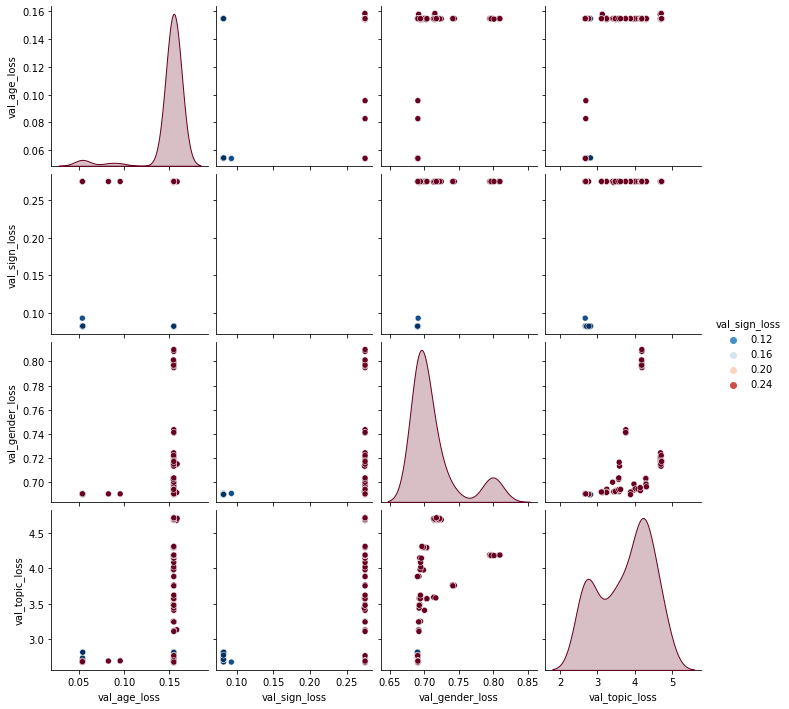

In [23]:
sns.pairplot(pGrid[["val_age_loss","val_sign_loss","val_gender_loss","val_topic_loss","val_loss"]],
             vars=["val_age_loss","val_sign_loss","val_gender_loss","val_topic_loss"],
             hue="val_sign_loss",palette='RdBu_r')

In [24]:
pGrid.loc[(pGrid.loss.isna()==False)&
          (pGrid.val_age_loss<0.1)&
          (pGrid.val_sign_loss<0.1)].sort_values(by="val_age_loss").head()

,nStartChnls,fSize,dOutR,lmbda,embSize,learningRate,lWeight,epoch,loss,gender_loss,age_loss,topic_loss,sign_loss,gender_accuracy,age_mae,topic_accuracy,sign_mae,val_loss,val_gender_loss,val_age_loss,val_topic_loss,val_sign_loss,val_gender_accuracy,val_age_mae,val_topic_accuracy,val_sign_mae,learning_rate
337,16.0,7.0,0.1,0.1,64.0,0.01,0.0,30.0,3.581101,0.680790,0.050435,2.683040,0.090200,0.578462,0.166010,0.344952,0.249929,3.587796,0.690912,0.053980,2.673572,0.092696,0.542188,0.179251,0.340625,0.248689,1.000000e-06
7,16.0,3.0,0.1,0.1,32.0,0.01,0.0,30.0,3.568467,0.680940,0.050398,2.683551,0.078586,0.578462,0.165839,0.344952,0.239864,3.577455,0.690960,0.053986,2.675526,0.081991,0.542188,0.179164,0.340625,0.244130,1.000000e-06
181,16.0,5.0,0.1,0.3,16.0,0.01,0.0,30.0,3.606886,0.681141,0.050455,2.707714,0.078553,0.578462,0.165756,0.344952,0.239770,3.624018,0.690725,0.054168,2.708406,0.081695,0.542188,0.179352,0.340625,0.243677,1.000000e-06
373,16.0,7.0,0.1,0.5,64.0,0.01,0.0,30.0,3.644539,0.681224,0.050467,2.726904,0.078525,0.578462,0.165745,0.344952,0.239700,3.664144,0.690592,0.054191,2.730372,0.081569,0.542188,0.179284,0.340625,0.243607,1.000000e-06
582,16.0,9.0,0.3,0.5,32.0,0.01,1.0,30.0,1.341127,0.681867,0.050615,2.795143,0.078721,0.578462,0.166692,0.344952,0.239153,1.351140,0.689958,0.054418,2.812482,0.082208,0.542188,0.180321,0.340625,0.241449,1.000000e-07


In [25]:
pGrid.sort_values(by="val_age_loss",ascending=True).head()

,nStartChnls,fSize,dOutR,lmbda,embSize,learningRate,lWeight,epoch,loss,gender_loss,age_loss,topic_loss,sign_loss,gender_accuracy,age_mae,topic_accuracy,sign_mae,val_loss,val_gender_loss,val_age_loss,val_topic_loss,val_sign_loss,val_gender_accuracy,val_age_mae,val_topic_accuracy,val_sign_mae,learning_rate
337,16.0,7.0,0.1,0.1,64.0,0.01,0.0,30.0,3.581101,0.680790,0.050435,2.683040,0.090200,0.578462,0.166010,0.344952,0.249929,3.587796,0.690912,0.053980,2.673572,0.092696,0.542188,0.179251,0.340625,0.248689,1.000000e-06
7,16.0,3.0,0.1,0.1,32.0,0.01,0.0,30.0,3.568467,0.680940,0.050398,2.683551,0.078586,0.578462,0.165839,0.344952,0.239864,3.577455,0.690960,0.053986,2.675526,0.081991,0.542188,0.179164,0.340625,0.244130,1.000000e-06
1753,64.0,7.0,0.5,0.3,32.0,0.01,0.0,30.0,3.729504,0.681130,0.050449,2.679786,0.277636,0.578462,0.165761,0.344952,0.446246,3.738391,0.690587,0.054055,2.678148,0.275098,0.542188,0.179273,0.340625,0.440234,1.000000e-10
493,16.0,9.0,0.1,0.1,32.0,0.01,0.0,30.0,3.766045,0.680834,0.050454,2.683260,0.277636,0.578462,0.165914,0.344952,0.446246,3.766737,0.690625,0.054060,2.673094,0.275098,0.542188,0.179139,0.340625,0.440234,1.000000e-08
1393,64.0,3.0,0.3,0.5,32.0,0.01,0.0,30.0,3.752126,0.681162,0.050455,2.687119,0.277636,0.578462,0.165827,0.344952,0.446246,3.765162,0.690572,0.054061,2.689675,0.275098,0.542188,0.179139,0.340625,0.440234,1.000000e-09


In [26]:
pGrid.sort_values(by="val_sign_loss",ascending=True).head()

,nStartChnls,fSize,dOutR,lmbda,embSize,learningRate,lWeight,epoch,loss,gender_loss,age_loss,topic_loss,sign_loss,gender_accuracy,age_mae,topic_accuracy,sign_mae,val_loss,val_gender_loss,val_age_loss,val_topic_loss,val_sign_loss,val_gender_accuracy,val_age_mae,val_topic_accuracy,val_sign_mae,learning_rate
534,16.0,9.0,0.1,0.5,64.0,0.01,1.0,30.0,1.361023,0.681890,0.150504,2.797227,0.078636,0.578462,0.316313,0.344952,0.239314,1.368685,0.689971,0.154759,2.808775,0.081517,0.542188,0.316830,0.340625,0.242178,1.000000e-06
373,16.0,7.0,0.1,0.5,64.0,0.01,0.0,30.0,3.644539,0.681224,0.050467,2.726904,0.078525,0.578462,0.165745,0.344952,0.239700,3.664144,0.690592,0.054191,2.730372,0.081569,0.542188,0.179284,0.340625,0.243607,1.000000e-06
181,16.0,5.0,0.1,0.3,16.0,0.01,0.0,30.0,3.606886,0.681141,0.050455,2.707714,0.078553,0.578462,0.165756,0.344952,0.239770,3.624018,0.690725,0.054168,2.708406,0.081695,0.542188,0.179352,0.340625,0.243677,1.000000e-06
409,16.0,7.0,0.3,0.3,64.0,0.01,0.0,30.0,3.704949,0.681176,0.150504,2.706524,0.078519,0.578462,0.316313,0.344952,0.239783,3.725917,0.690564,0.154759,2.710500,0.081868,0.542188,0.316830,0.340625,0.243309,1.000000e-07
7,16.0,3.0,0.1,0.1,32.0,0.01,0.0,30.0,3.568467,0.680940,0.050398,2.683551,0.078586,0.578462,0.165839,0.344952,0.239864,3.577455,0.690960,0.053986,2.675526,0.081991,0.542188,0.179164,0.340625,0.244130,1.000000e-06


In [27]:
pGrid.sort_values(by="val_gender_loss",ascending=True).head()

,nStartChnls,fSize,dOutR,lmbda,embSize,learningRate,lWeight,epoch,loss,gender_loss,age_loss,topic_loss,sign_loss,gender_accuracy,age_mae,topic_accuracy,sign_mae,val_loss,val_gender_loss,val_age_loss,val_topic_loss,val_sign_loss,val_gender_accuracy,val_age_mae,val_topic_accuracy,val_sign_mae,learning_rate
252,16.0,5.0,0.3,0.5,16.0,0.0100,1.0,30.0,1.360046,0.681866,0.150504,2.795249,0.078639,0.578462,0.316313,0.344952,0.239285,1.370691,0.689950,0.154759,2.814013,0.081999,0.542188,0.316830,0.340625,0.241820,1.000000e-08
543,16.0,9.0,0.3,0.1,16.0,0.0001,0.0,30.0,10.184847,0.684850,0.150504,3.811525,0.277636,0.576743,0.316313,0.015786,0.446246,10.261536,0.689955,0.154759,3.881391,0.275098,0.542188,0.316830,0.015625,0.440234,1.000000e-08
582,16.0,9.0,0.3,0.5,32.0,0.0100,1.0,30.0,1.341127,0.681867,0.050615,2.795143,0.078721,0.578462,0.166692,0.344952,0.239153,1.351140,0.689958,0.054418,2.812482,0.082208,0.542188,0.180321,0.340625,0.241449,1.000000e-07
534,16.0,9.0,0.1,0.5,64.0,0.0100,1.0,30.0,1.361023,0.681890,0.150504,2.797227,0.078636,0.578462,0.316313,0.344952,0.239314,1.368685,0.689971,0.154759,2.808775,0.081517,0.542188,0.316830,0.340625,0.242178,1.000000e-06
612,16.0,9.0,0.5,0.3,16.0,0.0100,1.0,30.0,1.336876,0.681561,0.150504,2.755513,0.078547,0.578462,0.316313,0.344952,0.239405,1.346585,0.690139,0.154759,2.771644,0.081999,0.542188,0.316830,0.340625,0.242167,1.000000e-07


In [28]:
pGrid.sort_values(by="val_topic_loss",ascending=True).head()

,nStartChnls,fSize,dOutR,lmbda,embSize,learningRate,lWeight,epoch,loss,gender_loss,age_loss,topic_loss,sign_loss,gender_accuracy,age_mae,topic_accuracy,sign_mae,val_loss,val_gender_loss,val_age_loss,val_topic_loss,val_sign_loss,val_gender_accuracy,val_age_mae,val_topic_accuracy,val_sign_mae,learning_rate
817,32.0,5.0,0.1,0.1,32.0,0.01,0.0,30.0,3.840189,0.680448,0.150504,2.676490,0.277636,0.578462,0.316313,0.344952,0.446246,3.840619,0.690392,0.154759,2.665257,0.275098,0.542188,0.316830,0.340625,0.440234,1.000000e-06
493,16.0,9.0,0.1,0.1,32.0,0.01,0.0,30.0,3.766045,0.680834,0.050454,2.683260,0.277636,0.578462,0.165914,0.344952,0.446246,3.766737,0.690625,0.054060,2.673094,0.275098,0.542188,0.179139,0.340625,0.440234,1.000000e-08
337,16.0,7.0,0.1,0.1,64.0,0.01,0.0,30.0,3.581101,0.680790,0.050435,2.683040,0.090200,0.578462,0.166010,0.344952,0.249929,3.587796,0.690912,0.053980,2.673572,0.092696,0.542188,0.179251,0.340625,0.248689,1.000000e-06
1842,64.0,9.0,0.3,0.1,32.0,0.01,1.0,30.0,1.308459,0.681174,0.150504,2.678663,0.277636,0.578462,0.316313,0.344952,0.446246,1.308727,0.690543,0.154759,2.673789,0.275098,0.542188,0.316830,0.340625,0.440234,1.000000e-09
769,32.0,3.0,0.5,0.1,64.0,0.01,0.0,30.0,3.841429,0.680833,0.150504,2.676092,0.277636,0.578462,0.316313,0.344952,0.446246,3.851216,0.690653,0.154759,2.674342,0.275098,0.542188,0.316830,0.340625,0.440234,1.000000e-06


the above results provides the followin insights about model topology<br>
* topic_classification did not benefit from loss_weights<br>
* learning rate 0.01 give most chances to converge to the best state<br>

Lets choose the models with least losses and fit on whole data

2022-06-19 17:27:57.702087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 17:27:57.770799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 17:27:57.771039: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 17:27:57.788627: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Number of parameters: 6801659


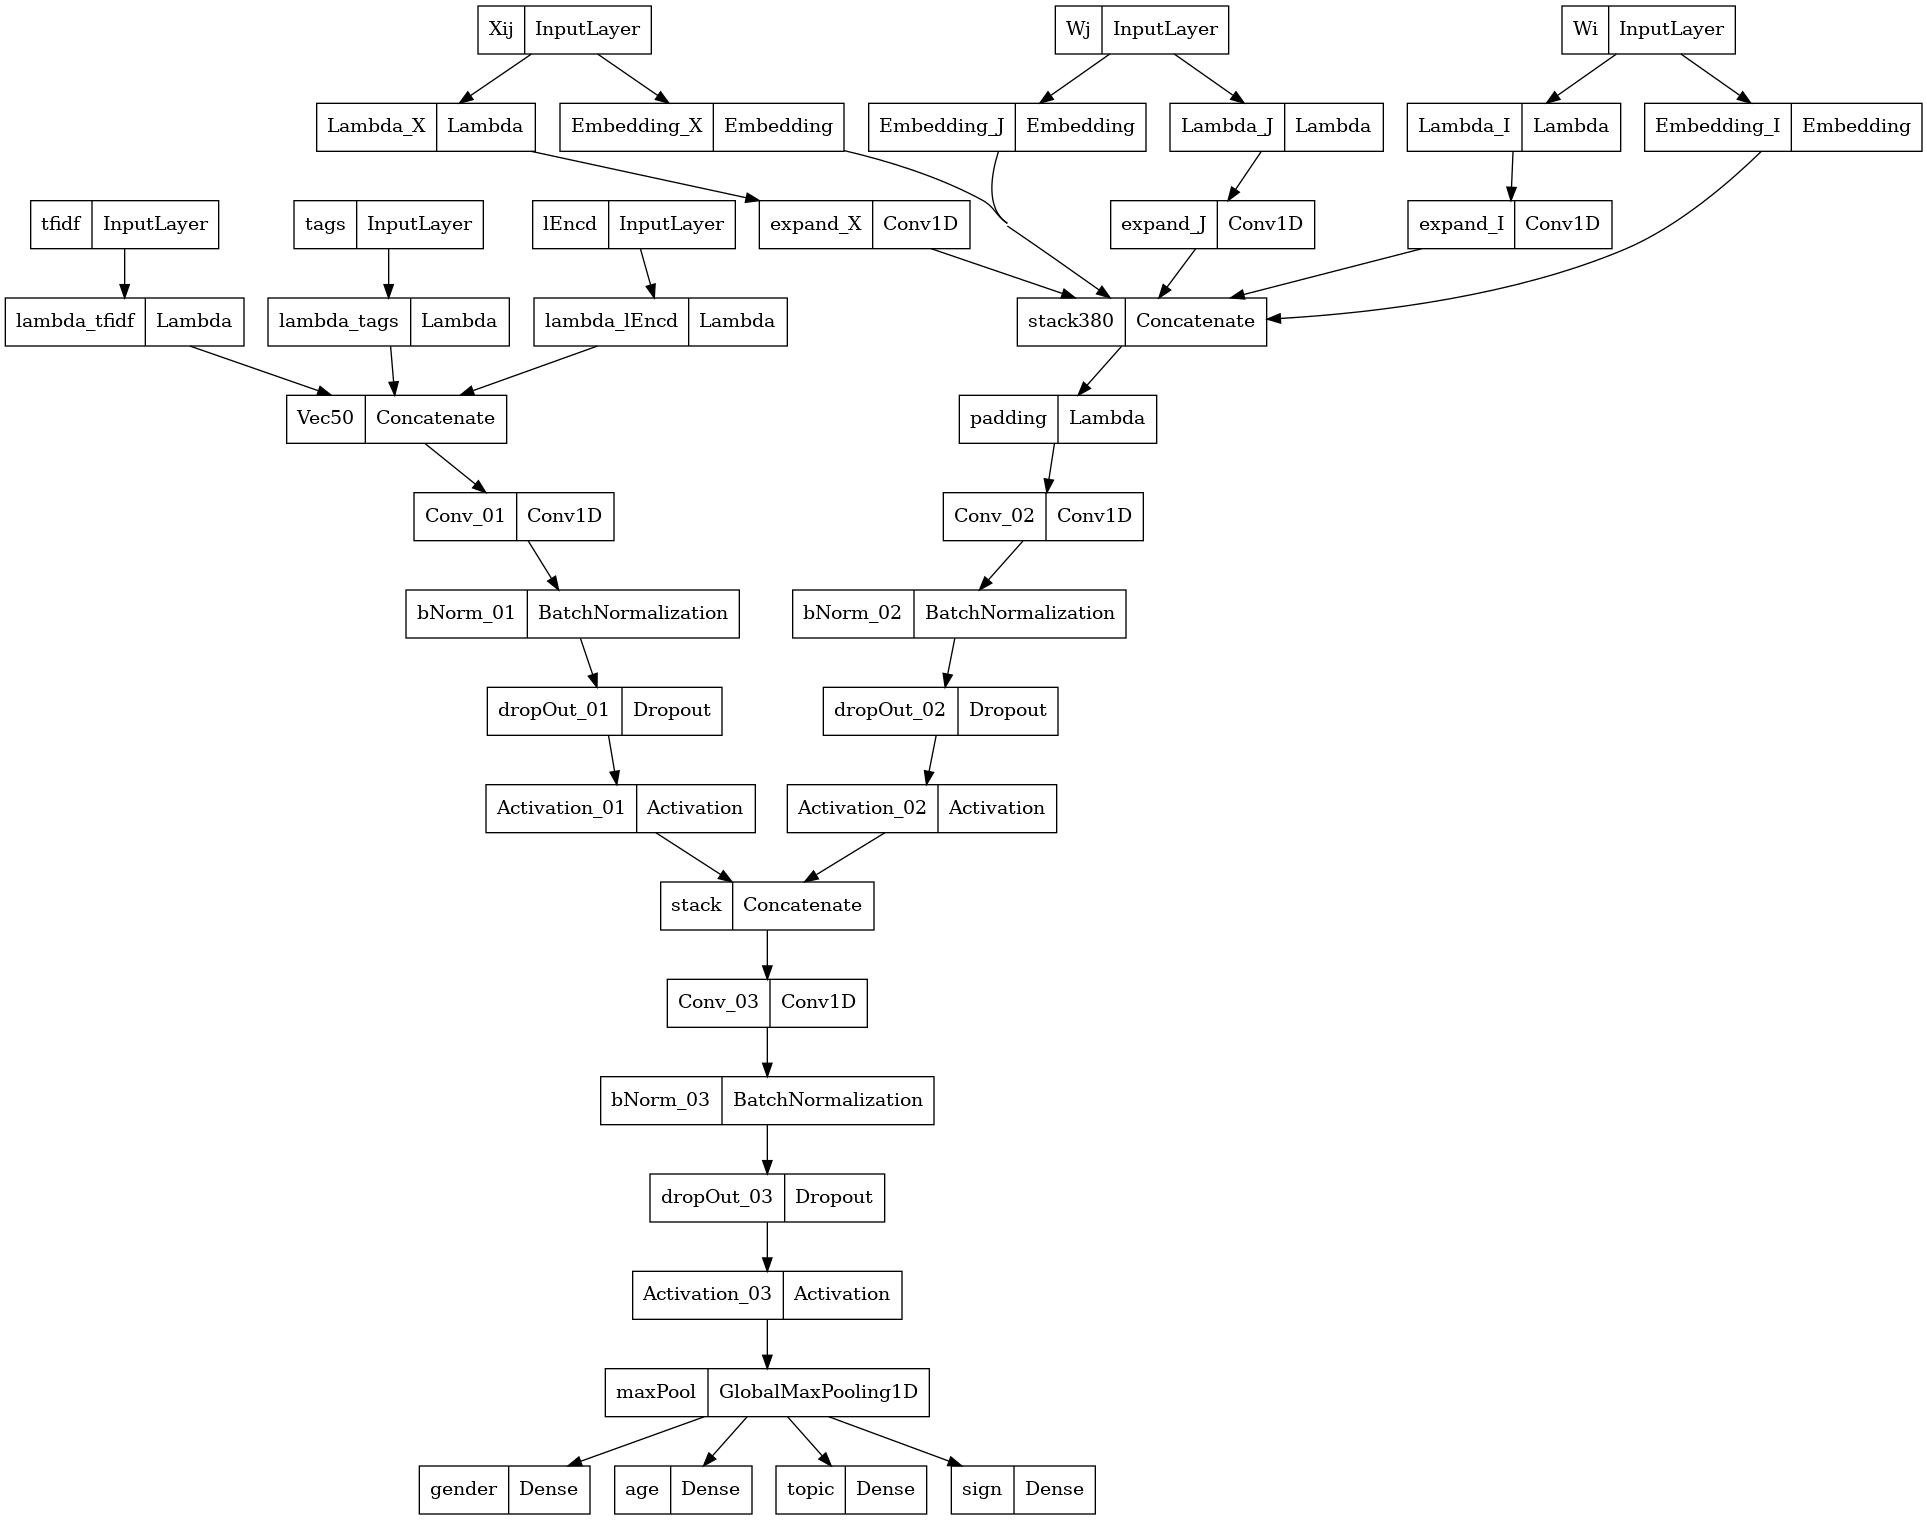

In [29]:
# lets train the model 582
i=582
LangNET = nlpNet(dict(pGrid.loc[i,pCols]))
print("Number of parameters:",LangNET.count_params())
display(plot_model(LangNET))

In [30]:
#review & update the gridpoint
gp = dict(pGrid.loc[i,pCols])
gp.update({'lWeight': 0.0})
gp

{'nStartChnls': 16.0,
 'fSize': 9.0,
 'dOutR': 0.3,
 'lmbda': 0.5,
 'embSize': 32.0,
 'learningRate': 0.01,
 'lWeight': 0.0}

In [31]:
# tensor board logs
logFile = "logs/hNet_tuning.har"
logDir = "logs"

In [33]:
# fit 582
fitparams =  dict(x=Xtrain,y=Ytrain,batch_size=32,epochs=20,validation_data=(Xval,Yval))
iModel = hNetTrain(nlpNet,'fit_val'+str(i),i,gp,fitparams,logFile,logDir,htune=False,verbose=0)

2022-06-19 17:28:10.809098: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-06-19 17:28:11.170099: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


In [34]:
# evaluate on production data
iModel.evaluate(Xprod,Yprod,batch_size=32);

67/67 [==============================] - 0s 6ms/step - loss: 3.5385 - gender_loss: 0.6921 - age_loss: 0.0491 - topic_loss: 2.6453 - sign_loss: 0.0803 - gender_accuracy: 0.5350 - age_mae: 0.1672 - topic_accuracy: 0.3771 - sign_mae: 0.2425


the gender_accuracy of 0.53 is equivalent to no learning, because simply assigning all datapoints to male/female will yeild similar accuracy. Even worse is topic_accuracy levels.<br>
hence modify the model topology with separate convolutional branches for each target output branch<br>
this will enhance target specific learnings<br>

In [35]:
def nlpNet(gridPoint):
    
    nStartChnls = int(gridPoint["nStartChnls"])
    fSize = int(gridPoint["fSize"])
    dOutR = gridPoint["dOutR"]
    lmbda = gridPoint["lmbda"]
    embSize = int(gridPoint["embSize"])
    lr = gridPoint['learningRate']
    lWeight = bool(gridPoint['lWeight'])
    
    DTYPE = float    
    global nVocab
    
    # Random consistency seed
    np.random.seed(129)
    tf.random.set_seed(129)
    
    # 50 len vectors
    I_tags = Input(shape=(50),name='tags')    # POS Tags
    I_tfidf = Input(shape=(50),name='tfidf')  # TF-IDF Vector
    I_lEncd = Input(shape=(50),name='lEncd')  # Label Encoded Vector
    
    # expand channels
    expTags = Lambda(tf.expand_dims,name='lambda_tags',arguments=dict(axis=-1))(I_tags)
    expTfidf = Lambda(tf.expand_dims,name='lambda_tfidf',arguments=dict(axis=-1))(I_tfidf)
    expLencd = Lambda(tf.expand_dims,name='lambda_lEncd',arguments=dict(axis=-1))(I_lEncd)
    
    # stack
    stack50 = Concatenate(name='Vec50')([expTags,expTfidf,expLencd])
    
    # ConvBlock builder
    def convBlock(N,in_tensor,filters,window,strides,dRate,pad='same'):
        conv = Conv1D(filters=filters,kernel_size=window,name='Conv_%02d'%N,dtype=DTYPE,
                      strides=strides,padding=pad,data_format='channels_last')(in_tensor)
        bNorm = BatchNormalization(name='bNorm_%02d'%N)(conv)
        dOut = Dropout(dRate,name='dropOut_%02d'%N)(bNorm)        
        act = Activation(tf.nn.tanh,name='Activation_%02d'%N)(dOut)
        return act,act.get_shape().as_list()
    
    # convolution block 1
    cb1,chnls = convBlock(1,stack50,nStartChnls,fSize,1,dOutR) # hParams nStartChnls,fSize,dOutR
    
    # 380 len vectors
    I_Wi = Input(shape=(380),name='Wi')       # Skipgram word[0]
    I_Wj = Input(shape=(380),name='Wj')       # Skipgram word[1]
    I_Xij = Input(shape=(380),name='Xij')     # Co-Occurance Vector
    
    # embedding layers
    embI = Embedding(input_dim=nVocab,output_dim=embSize,        # hParams embSize
                     input_length=380,name='Embedding_I')(I_Wi)
    embJ = Embedding(input_dim=nVocab,output_dim=embSize,        # hParams embSize
                     input_length=380,name='Embedding_J')(I_Wj)
    embX = Embedding(input_dim=nVocab,output_dim=embSize,        # hParams embSize
                     input_length=380,name='Embedding_X')(I_Xij)
    
    # vector Convolutions
    expI = Conv1D(filters=embSize,kernel_size=fSize,strides=1, # hParams embSize, fSize
                  name='expand_I',padding='same',dtype=DTYPE,
                  data_format='channels_last')(Lambda(tf.expand_dims,
                                                      name='Lambda_I',arguments=dict(axis=-1))(I_Wi))
    expJ = Conv1D(filters=embSize,kernel_size=fSize,strides=1, # hParams embSize, fSize
                  name='expand_J',padding='same',dtype=DTYPE,
                  data_format='channels_last')(Lambda(tf.expand_dims,
                                                      name='Lambda_J',arguments=dict(axis=-1))(I_Wj))
    expX = Conv1D(filters=embSize,kernel_size=fSize,strides=1, # hParams embSize, fSize
                  name='expand_X',padding='same',dtype=DTYPE,
                  data_format='channels_last')(Lambda(tf.expand_dims,
                                                      name='Lambda_X',arguments=dict(axis=-1))(I_Xij))
    
    # stack embeddings & Convolutions
    stack380 = Concatenate(name='stack380')([expI,embI,expJ,embJ,expX,embX])
    
    # kernel Compute
    #no = ((ni-k+2p)/s)+1
    # no = 50, ni = 380
    k=s=8
    p=10
    
    # padding
    pdng = ((0, 0), (10, 10), (0, 0))
    pad = Lambda(tf.pad,name='padding',arguments=dict(paddings=pdng))(stack380)
    
    # convolution block 2
    cb2,chnls = convBlock(2,pad,nStartChnls,k,s,dOutR,pad='valid') # hParams nStartChnls,fSize,dOutR
    
    # stack all vectors
    stack = Concatenate(name='stack')([cb1,cb2])
    
    # convolution block branches
    chnls = stack.get_shape().as_list()
    cb3, chnls = convBlock(3,stack,chnls[-1]*2,fSize,1,dOutR) # hParams fSize,dOutR
    chnls = stack.get_shape().as_list()
    cb4, chnls = convBlock(4,stack,chnls[-1]*2,fSize,1,dOutR) # hParams fSize,dOutR
    chnls = stack.get_shape().as_list()
    cb5, chnls = convBlock(5,stack,chnls[-1]*2,fSize,1,dOutR) # hParams fSize,dOutR
    chnls = stack.get_shape().as_list()
    cb6, chnls = convBlock(6,stack,chnls[-1]*2,fSize,1,dOutR) # hParams fSize,dOutR
    
    # MaxPooling
    pool3 = GlobalMaxPool1D(name='maxPool3',data_format='channels_last',dtype=DTYPE)(cb3)
    pool4 = GlobalMaxPool1D(name='maxPool4',data_format='channels_last',dtype=DTYPE)(cb4)
    pool5 = GlobalMaxPool1D(name='maxPool5',data_format='channels_last',dtype=DTYPE)(cb5)
    pool6 = GlobalMaxPool1D(name='maxPool6',data_format='channels_last',dtype=DTYPE)(cb6)
    
    # output layers
    gender = Dense(1,activation='sigmoid',name='gender',dtype=DTYPE,kernel_regularizer=regularizers.l2(lmbda))(pool3)
    age = Dense(1,activation='relu',name='age',dtype=DTYPE,kernel_regularizer=regularizers.l2(lmbda))(pool4)
    topic = Dense(40,activation='softmax',name='topic',dtype=DTYPE,kernel_regularizer=regularizers.l2(lmbda))(pool5)
    sign = Dense(1,activation='relu',name='sign',dtype=DTYPE,kernel_regularizer=regularizers.l2(lmbda))(pool6)
        # hParam lmbda
    
    # assemble model
    model = Model(name='Authorship_CNN',
                  inputs=[I_Wi,I_Wj,I_Xij,I_tags,I_tfidf,I_lEncd],
                  outputs=[gender,age,topic,sign])
    
    # optimisers
    optim = optimizers.Adagrad(learning_rate=lr)
    
    # losses
    losses = {'gender':'binary_crossentropy',
            'age':'mse',
            'topic':'categorical_crossentropy',
            'sign':'mse'}
    loss_weights = {'gender':0.2,
            'age':0.2,
            'topic':0.4,
            'sign':0.2}
    
    # metrics
    metrics = {'gender':'accuracy',
               'age':'mae',
               'topic':'accuracy',
               'sign':'mae'}
    
    # compile model
    if lWeight:
        model.compile(optimizer=optim,loss=losses,metrics=metrics,loss_weights=loss_weights)
    else:
        model.compile(optimizer=optim,loss=losses,metrics=metrics)
    
    return model

In [36]:
fitparams =  dict(x=Xtrain,y=Ytrain,batch_size=32,epochs=20,validation_data=(Xval,Yval))
iModel = hNetTrain(nlpNet,'multiBranch'+str(i),i,gp,fitparams,logFile,logDir,htune=False,verbose=0)

Number of parameters: 6857915


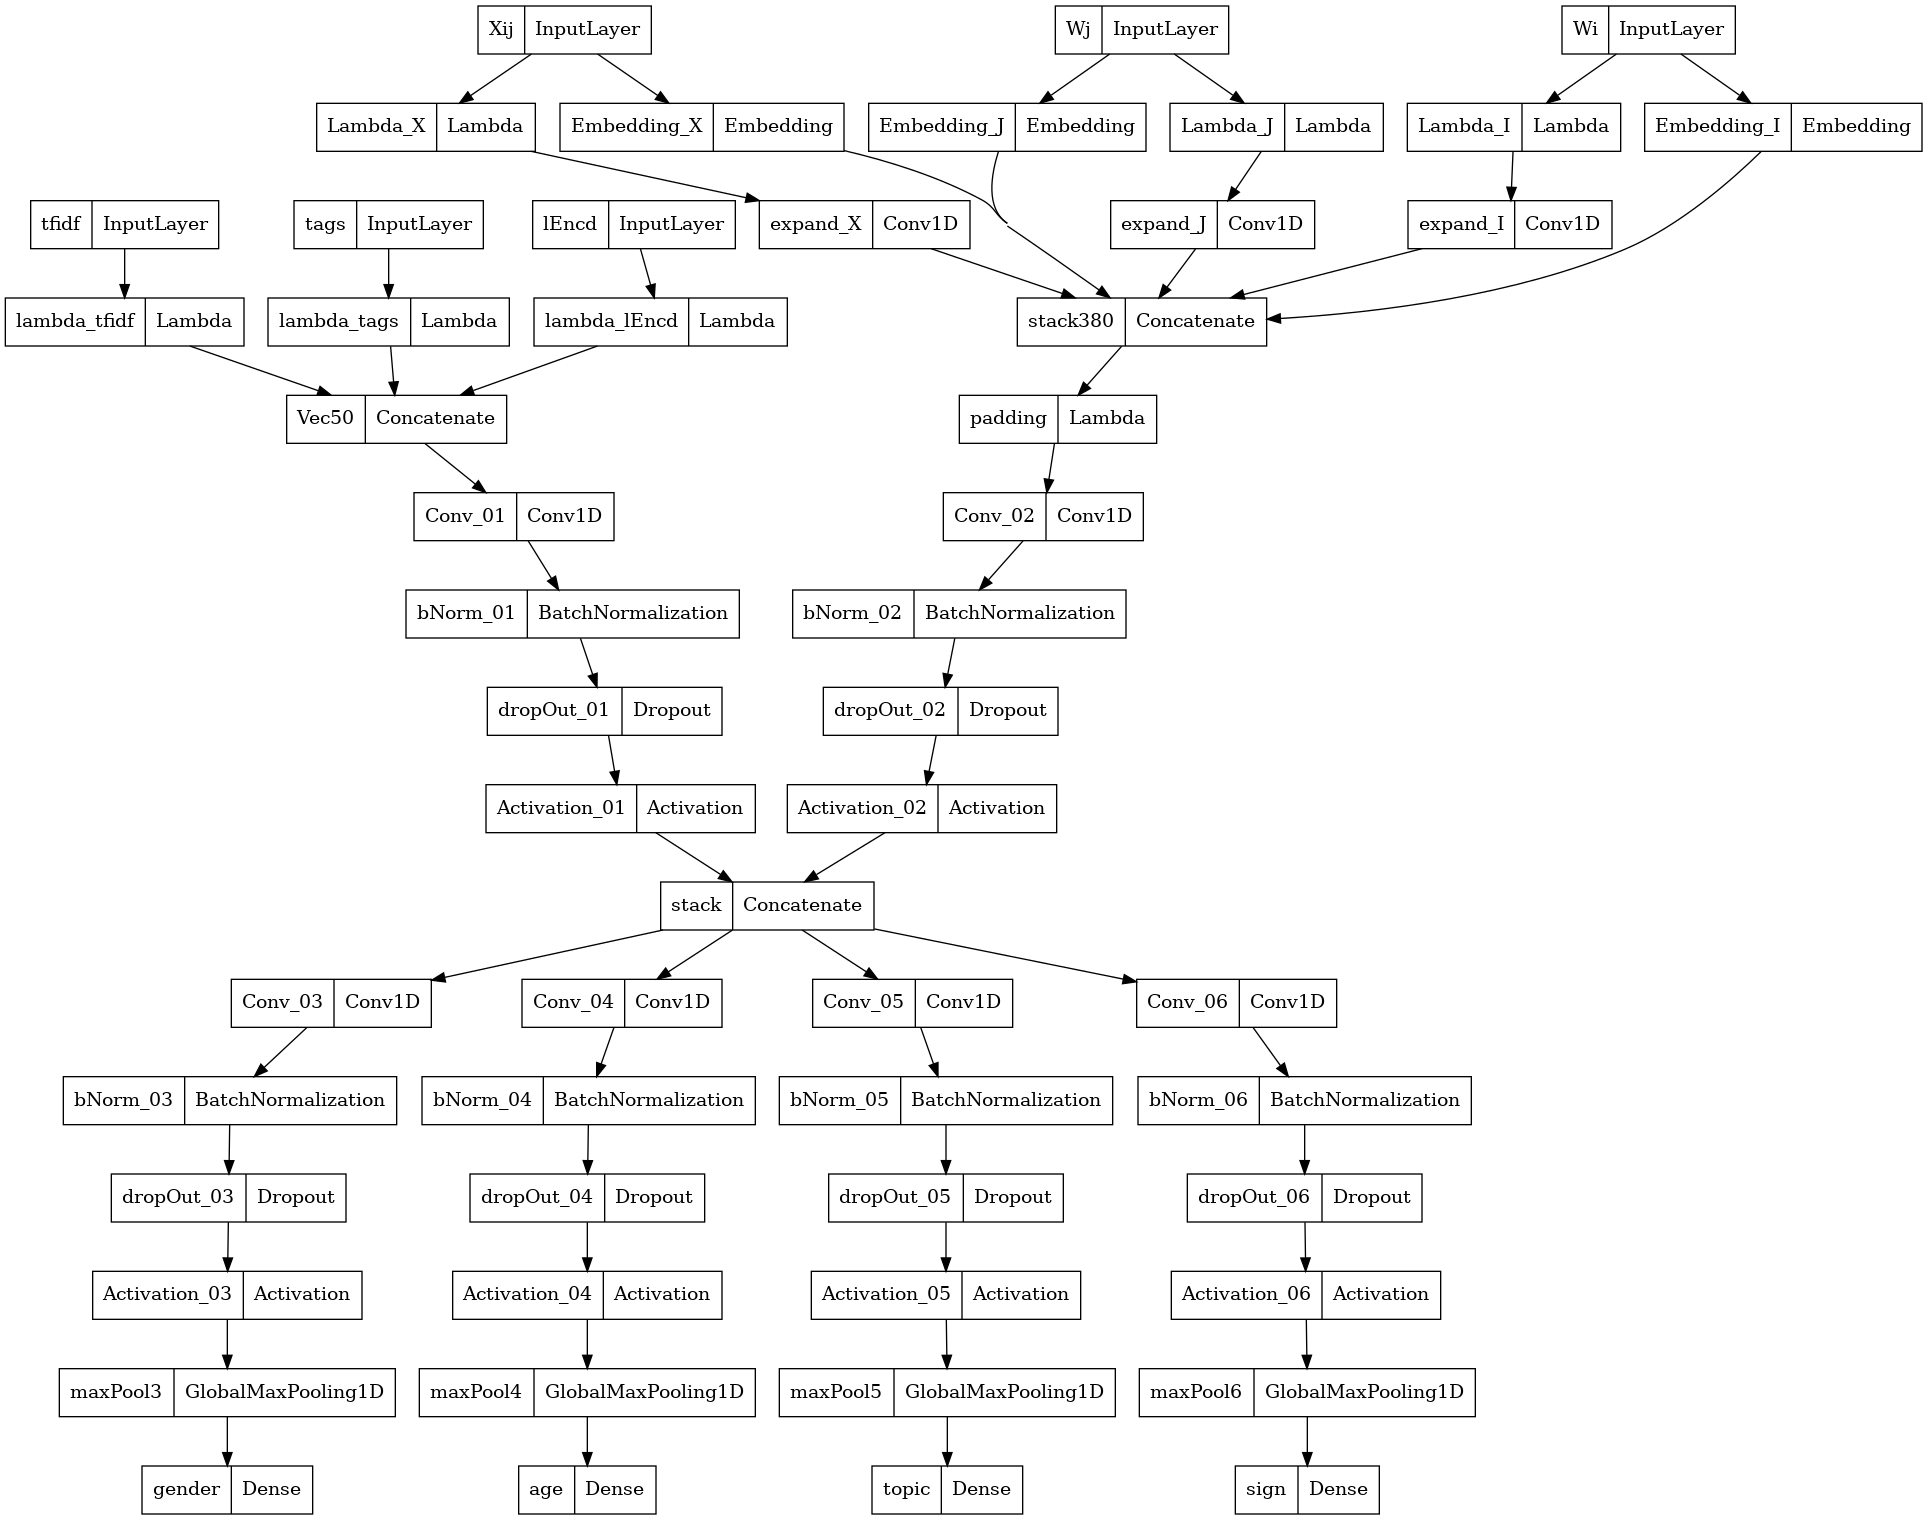

In [37]:
print("Number of parameters:",iModel.count_params())
display(plot_model(iModel))

In [38]:
# evaluate on production data
iModel.evaluate(Xprod,Yprod,batch_size=32);

67/67 [==============================] - 0s 6ms/step - loss: 3.5403 - gender_loss: 0.6922 - age_loss: 0.0491 - topic_loss: 2.6458 - sign_loss: 0.0806 - gender_accuracy: 0.5350 - age_mae: 0.1674 - topic_accuracy: 0.3771 - sign_mae: 0.2426


clearly the results have not imporved any better. Lets create a DL for the classifier

In [22]:
def nlpNet(gridPoint):
    
    nStartChnls = int(gridPoint["nStartChnls"])
    fSize = int(gridPoint["fSize"])
    dOutR = gridPoint["dOutR"]
    lmbda = gridPoint["lmbda"]
    embSize = int(gridPoint["embSize"])
    lr = gridPoint['learningRate']
    lWeight = bool(gridPoint['lWeight'])
    
    DTYPE = float    
    global nVocab
    global BlockNo
    BlockNo = 1
    
    # Random consistency seed
    np.random.seed(129)
    tf.random.set_seed(129)
    
    # 50 len vectors
    I_tags = Input(shape=(50),name='tags')    # POS Tags
    I_tfidf = Input(shape=(50),name='tfidf')  # TF-IDF Vector
    I_lEncd = Input(shape=(50),name='lEncd')  # Label Encoded Vector
    
    # expand channels
    expTags = Lambda(tf.expand_dims,name='lambda_tags',arguments=dict(axis=-1))(I_tags)
    expTfidf = Lambda(tf.expand_dims,name='lambda_tfidf',arguments=dict(axis=-1))(I_tfidf)
    expLencd = Lambda(tf.expand_dims,name='lambda_lEncd',arguments=dict(axis=-1))(I_lEncd)
    
    # stack
    stack50 = Concatenate(name='Vec50')([expTags,expTfidf,expLencd])
    
    # 380 len vectors
    I_Wi = Input(shape=(380),name='Wi')       # Skipgram word[0]
    I_Wj = Input(shape=(380),name='Wj')       # Skipgram word[1]
    I_Xij = Input(shape=(380),name='Xij')     # Co-Occurance Vector
    
    # embedding layers
    embI = Embedding(input_dim=nVocab,output_dim=embSize,        # hParams embSize
                     input_length=380,name='Embedding_I')(I_Wi)
    embJ = Embedding(input_dim=nVocab,output_dim=embSize,        # hParams embSize
                     input_length=380,name='Embedding_J')(I_Wj)
    embX = Embedding(input_dim=nVocab,output_dim=embSize,        # hParams embSize
                     input_length=380,name='Embedding_X')(I_Xij)
    
    # vector Convolutions
    expI = Conv1D(filters=embSize,kernel_size=fSize,strides=1, # hParams embSize, fSize
                  name='expand_I',padding='same',dtype=DTYPE,
                  data_format='channels_last')(Lambda(tf.expand_dims,
                                                      name='Lambda_I',arguments=dict(axis=-1))(I_Wi))
    expJ = Conv1D(filters=embSize,kernel_size=fSize,strides=1, # hParams embSize, fSize
                  name='expand_J',padding='same',dtype=DTYPE,
                  data_format='channels_last')(Lambda(tf.expand_dims,
                                                      name='Lambda_J',arguments=dict(axis=-1))(I_Wj))
    expX = Conv1D(filters=embSize,kernel_size=fSize,strides=1, # hParams embSize, fSize
                  name='expand_X',padding='same',dtype=DTYPE,
                  data_format='channels_last')(Lambda(tf.expand_dims,
                                                      name='Lambda_X',arguments=dict(axis=-1))(I_Xij))
    
    # stack embeddings & Convolutions
    stack380 = Concatenate(name='stack380')([expI,embI,expJ,embJ,expX,embX])
    chnls = stack380.get_shape().as_list()    
    
    # ConvBlock builder
    def convBlock(in_tensor,filters,window,strides,dRate,pad='same'):
        global BlockNo
        conv = Conv1D(filters=filters,kernel_size=window,name='Conv_%02d'%BlockNo,dtype=DTYPE,
                      strides=strides,padding=pad,data_format='channels_last')(in_tensor)
        bNorm = BatchNormalization(name='bNorm_%02d'%BlockNo)(conv)
        dOut = Dropout(dRate,name='dropOut_%02d'%BlockNo)(bNorm)        
        act = Activation(tf.nn.elu,name='Activation_%02d'%BlockNo)(dOut)
        BlockNo+=1
        return act,act.get_shape().as_list()
    
    def skipSet(in_tensor,filters,window,dRate,strides):
        cbs,chnls = convBlock(in_tensor,filters*2,window,strides,dRate)
        cb1,chnl  = convBlock(in_tensor,filters/2,window,strides,dRate)
        cb2,chnl  = convBlock(cb1,filters/2,window,1,dRate)
        cb3,chnl  = convBlock(cb2,filters*2,window,1,dRate)
        add = Add(name='Add_%02d'%BlockNo)([cb3,cbs])
        relu = Activation(tf.nn.elu,name='Add_activation_%02d'%BlockNo)(add)
        return relu,relu.get_shape().as_list()
    
    def reConvSet(in_tensor,filters,window,dRate):
        cb1,chnl  = convBlock(in_tensor,filters/4,window,1,dRate)
        cb2,chnl  = convBlock(cb1,filters/4,window,1,dRate)
        cb3,chnl  = convBlock(cb1,filters,window,1,dRate)
        add = Add(name='Add_%02d'%BlockNo)([cb3,in_tensor])
        relu = Activation(tf.nn.elu,name='Add_activation_%02d'%BlockNo)(add)
        return relu,relu.get_shape().as_list()
    
    # convolution branch 1
    conv1 = Conv1D(filters=nStartChnls,kernel_size=fSize, # hParams nStartChnls,fSize,
                  name='Conv_%02d'%BlockNo,dtype=DTYPE,padding='same',
                  data_format='channels_last')(stack50)
    BlockNo+=1
    chnls = conv1.get_shape().as_list()
    
    # convolution branch 2
    chnls = stack380.get_shape().as_list()    
    cbE1,chnls = convBlock(stack380,chnls[-1]/4,4,4,dOutR,pad='valid')
    
    # kernel Compute
    #no = ((ni-k+2p)/s)+1
    # k = 95/50
    # no = 50, ni = 95
    k=s=8
    p=10
    
    # padding & matching
    pdng = ((0, 0), (3, 3), (0, 0))
    pad = Lambda(tf.pad,name='padding',arguments=dict(paddings=pdng))(cbE1)
    chnls = pad.get_shape().as_list()
    conv2 = Conv1D(filters=nStartChnls,kernel_size=2, # hParams nStartChnls,fSize,
                  name='Conv_%02d'%BlockNo,dtype=DTYPE,padding='valid',strides=2,
                  data_format='channels_last')(pad)
    BlockNo+=1
    chnls = conv2.get_shape().as_list()
    
    # stack all vectors
    stack = Concatenate(name='stack')([conv1,conv2])
    chnls = stack.get_shape().as_list()
    
    inBlock = stack
    while chnls[1]>2:
        Bs,chnls = skipSet(inBlock,chnls[-1],fSize,dOutR,4)
        Bns,chnls = reConvSet(Bs,chnls[-1],fSize,dOutR)
        Bns,chnls = reConvSet(Bs,chnls[-1],fSize,dOutR)
        inBlock = Bns
    
    # prediction branches
    DLvec = Bns
    genderConv,_ = convBlock(DLvec,2,fSize,1,dOutR)
    ageConv,_ = convBlock(DLvec,50,fSize,1,dOutR)
    topicConv,_ = convBlock(DLvec,40,fSize,1,dOutR)
    signConv,_ = convBlock(DLvec,50,fSize,1,dOutR)
    
    # output layers
    gender = Dense(1,activation='sigmoid',name='gender',dtype=DTYPE,
                   kernel_regularizer=regularizers.l2(lmbda))(Flatten(name='fGen')(genderConv))
    age = Dense(1,activation='relu',name='age',dtype=DTYPE,
                kernel_regularizer=regularizers.l2(lmbda))(Flatten(name='fAge')(ageConv))
    topic = Dense(40,activation='softmax',name='topic',dtype=DTYPE,
                  kernel_regularizer=regularizers.l2(lmbda))(Flatten(name='fTopic')(topicConv))
    sign = Dense(1,activation='relu',name='sign',dtype=DTYPE,
                 kernel_regularizer=regularizers.l2(lmbda))(Flatten(name='fSign')(signConv))
        # hParam lmbda
    
   # assemble model
    model = Model(name='Authorship_CNN',
                  inputs=[I_Wi,I_Wj,I_Xij,I_tags,I_tfidf,I_lEncd],
                  outputs=[gender,age,topic,sign])
    
    # optimisers
    optim = optimizers.Adagrad(learning_rate=lr)
    
    # losses
    losses = {'gender':'binary_crossentropy',
            'age':'mse',
            'topic':'categorical_crossentropy',
            'sign':'mse'}# assemble model
    model = Model(name='Authorship_CNN',
                  inputs=[I_Wi,I_Wj,I_Xij,I_tags,I_tfidf,I_lEncd],
                  outputs=[gender,age,topic,sign])
    
    # optimisers
    optim = optimizers.Adagrad(learning_rate=lr)
    
    # losses
    losses = {'gender':'binary_crossentropy',
            'age':'mse',
            'topic':'categorical_crossentropy',
            'sign':'mse'}
    # metrics
    metrics = {'gender':[tf.keras.metrics.Accuracy(),tf.keras.metrics.Recall(),tf.keras.metrics.Precision()],
               'age':'accuracy',
               'topic':[tf.keras.metrics.Accuracy(),tf.keras.metrics.Recall(),tf.keras.metrics.Precision()],
               'sign':'accuracy'}
    
    model.compile(optimizer=optim,loss=losses,metrics=metrics)
    
    return model

In [23]:
# tensor board logs
logFile = "logs/hNet_tuning.har"
logDir = "logs"

In [26]:
# hyperParameters
grid = dict(nStartChnls=[16,32],
            fSize=[3,5,7,9],
            dOutR=[0.1,0.3],
            lmbda=[0.1,0.3],
            embSize=[16,32],
            learningRate=[1e-2,1e-4],
            lWeight=[True])

pCols = list(grid.keys())

pGrid = pd.DataFrame(columns=pCols)
# gridpoint dataframe
for gp in [np.array([c,f,d,l2,e,lr,lw]) 
           for c in grid['nStartChnls']
           for f in grid['fSize']
           for d in grid['dOutR']
           for l2 in grid['lmbda']
           for e in grid['embSize']
           for lr in grid['learningRate']
           for lw in grid['lWeight']]:
    dtmp = pd.DataFrame(gp.reshape(1,-1),columns=pCols)
    pGrid = pd.merge(pGrid,dtmp,how='outer',on=pCols)

pGrid["epoch"]=np.nan
pGrid

,nStartChnls,fSize,dOutR,lmbda,embSize,learningRate,lWeight,epoch
0,16.0,3.0,0.1,0.1,16.0,0.0100,1.0,NaN
1,16.0,3.0,0.1,0.1,16.0,0.0001,1.0,NaN
2,16.0,3.0,0.1,0.1,32.0,0.0100,1.0,NaN
3,16.0,3.0,0.1,0.1,32.0,0.0001,1.0,NaN
4,16.0,3.0,0.1,0.3,16.0,0.0100,1.0,NaN
...,...,...,...,...,...,...,...,...
123,32.0,9.0,0.3,0.1,32.0,0.0001,1.0,NaN
124,32.0,9.0,0.3,0.3,16.0,0.0100,1.0,NaN
125,32.0,9.0,0.3,0.3,16.0,0.0001,1.0,NaN
126,32.0,9.0,0.3,0.3,32.0,0.0100,1.0,NaN


In [45]:
# model fitting arguments
fitparams =  dict(x=Xtrain,y=Ytrain,batch_size=32,epochs=20,steps_per_epoch = 100,
                  validation_data=(Xval,Yval),validation_steps = 10)

In [46]:
# random grid search
for i in tqdm(np.random.choice(pGrid.loc[pGrid.epoch.isna()].index,40,replace=False),desc="randomSearch"):
    iModel = hNetTrain(nlpNet,'dlTune'+str(i),i,dict(pGrid.loc[i,pCols]),fitparams,logFile,logDir,htune=True,verbose=0)

randomSearch: 100%|███████████████████████████| 40/40 [1:01:48<00:00, 92.71s/it]


In [47]:
# save gridSearch history
file = open('DLpGrid.har','wb')
pickle.dump(pGrid,file)
file.close()

In [27]:
# read from disk
file = open('DLpGrid.har','rb')
pGrid2 = pickle.load(file)
file.close()
file = open('pGrid.har','rb')
pGrid1 = pickle.load(file)
file.close()

review results

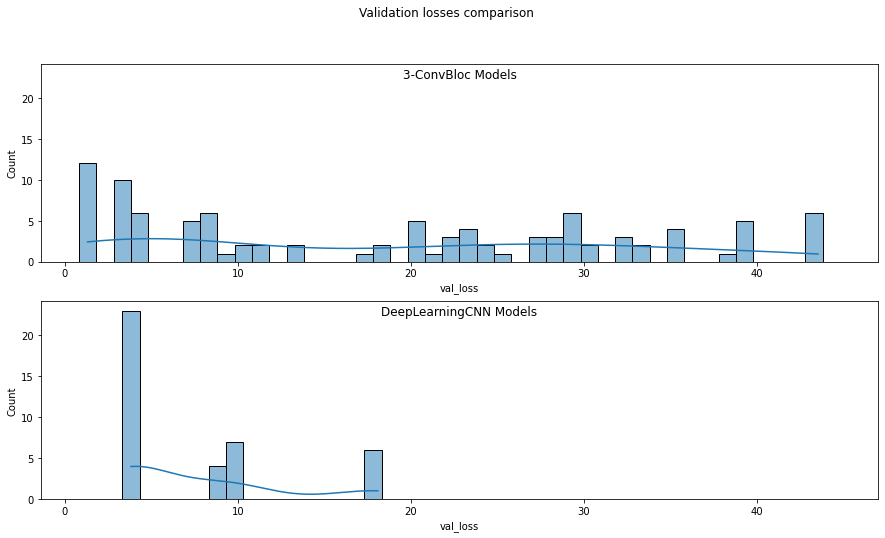

In [84]:
plt.figure(figsize=(15,8))
plt.suptitle("Validation losses comparison")
plt.subplot(2,1,1)
plt.title('3-ConvBloc Models',y=0.9)
ax1 = sns.histplot(pGrid1,x="val_loss",kde=True,discrete=True)
plt.subplot(2,1,2,sharex=ax1,sharey=ax1)
plt.title('DeepLearningCNN Models',y=0.9)
sns.histplot(pGrid2,x="val_loss",kde=True,discrete=True);

it could be seen from the comparison that 
* deep learning models performed no better than shallow models
    * the lower loss seen in 3-ConvBloc models is due to weighted sum (otherwise equivalent losses)
* irrespective of the model topology, the least loss acheivable is around 3 for the given case
    * this is attributed to the extent of variability that the NLP problem brings to the network, yet with insufficient datapoints to learn from, the models have failed to perform as intended
        * the constraint on traing data arises primarily due to computational & memory constraints
        * the dataset was limited to 10000 documents for training
    * given better computational & memory capabilities, the models are bound to perform better

lets summarise the prediction & results from the best model available

In [87]:
pGrid2.loc[(pGrid.loss.isna()==False)&
          (pGrid.val_age_loss<0.1)&
          (pGrid.val_sign_loss<0.1)].sort_values(by="val_loss",ascending=True).head()

,nStartChnls,fSize,dOutR,lmbda,embSize,learningRate,lWeight,epoch,loss,gender_loss,age_loss,topic_loss,sign_loss,gender_accuracy,gender_recall_4,gender_precision_4,age_accuracy,topic_accuracy,topic_recall_5,topic_precision_5,sign_accuracy,val_loss,val_gender_loss,val_age_loss,val_topic_loss,...,val_topic_precision_77,gender_recall_78,gender_precision_78,topic_recall_79,topic_precision_79,val_gender_recall_78,val_gender_precision_78,val_topic_recall_79,val_topic_precision_79,gender_recall_80,gender_precision_80,topic_recall_81,topic_precision_81,val_gender_recall_80,val_gender_precision_80,val_topic_recall_81,val_topic_precision_81,gender_recall_82,gender_precision_82,topic_recall_83,topic_precision_83,val_gender_recall_82,val_gender_precision_82,val_topic_recall_83,val_topic_precision_83
10,16.0,3.0,0.3,0.1,32.0,0.01,1.0,20.0,3.828754,0.695406,0.061108,2.822139,0.093988,0.0,NaN,NaN,0.012500,0.0,NaN,NaN,0.059375,3.815593,0.721921,0.062765,2.798031,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,16.0,5.0,0.1,0.1,32.0,0.01,1.0,20.0,3.782874,0.688811,0.053546,2.779567,0.084235,0.0,NaN,NaN,0.012500,0.0,NaN,NaN,0.065625,3.820866,0.698282,0.059986,2.811275,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16.0,3.0,0.1,0.1,32.0,0.01,1.0,20.0,3.783153,0.689253,0.053170,2.782482,0.083125,0.0,NaN,NaN,0.012500,0.0,NaN,NaN,0.065312,3.821711,0.698241,0.059643,2.816087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,16.0,9.0,0.1,0.1,16.0,0.01,1.0,20.0,3.780395,0.688103,0.055290,2.768568,0.086936,0.0,NaN,NaN,0.012812,0.0,NaN,NaN,0.065312,3.823557,0.696623,0.059493,2.810220,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,32.0,3.0,0.3,0.1,16.0,0.01,1.0,20.0,3.841720,0.691970,0.067792,2.831195,0.092708,0.0,NaN,NaN,0.012500,0.0,NaN,NaN,0.062188,3.828374,0.714285,0.062975,2.813472,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


lets train model at gridPoint 10

In [92]:
dict(pGrid2.loc[10,pCols])

{'nStartChnls': 16.0,
 'fSize': 3.0,
 'dOutR': 0.3,
 'lmbda': 0.1,
 'embSize': 32.0,
 'learningRate': 0.01,
 'lWeight': 1.0}

In [28]:
# model fitting arguments
i=10
fitparams =  dict(x=Xtrain,y=Ytrain,batch_size=32,epochs=20,validation_data=(Xval,Yval))
iModel = hNetTrain(nlpNet,'FINAL',i,dict(pGrid2.loc[i,pCols]),fitparams,logFile,logDir,htune=False,verbose=0)

2022-06-19 21:37:02.785996: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 21:37:02.895671: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 21:37:02.895836: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 21:37:02.914015: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Number of parameters: 7284039


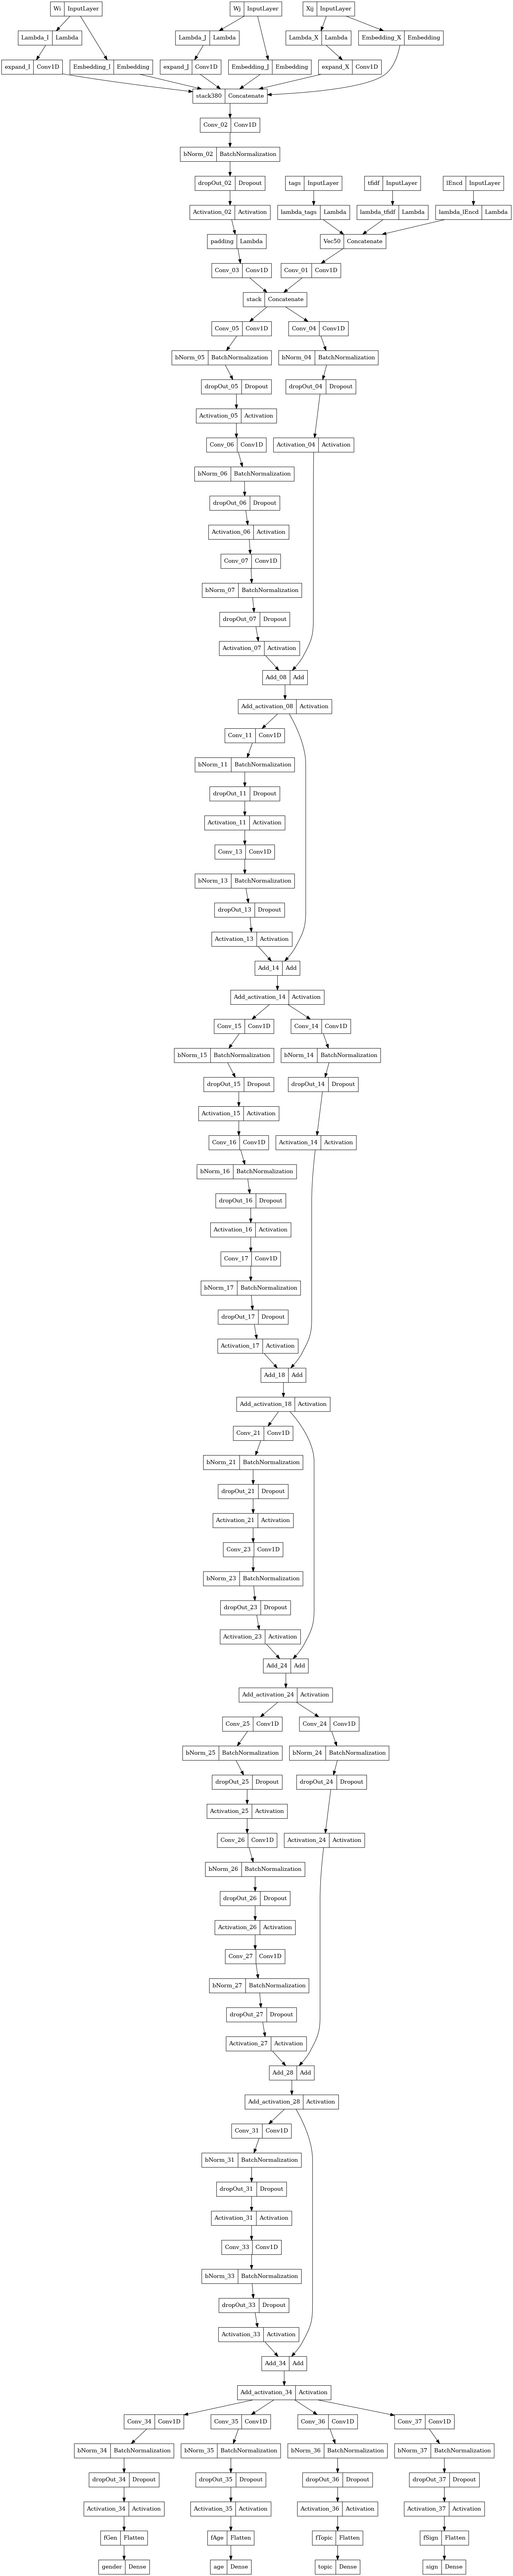

In [94]:
print("Number of parameters:",iModel.count_params())
display(plot_model(iModel))

In [97]:
# evaluate model on production data
iModel.evaluate(Xprod,Yprod,batch_size=32);

67/67 [==============================] - 1s 8ms/step - loss: 3.5012 - gender_loss: 0.6940 - age_loss: 0.0493 - topic_loss: 2.6253 - sign_loss: 0.0803 - gender_accuracy: 0.0000e+00 - gender_recall_84: 1.0000 - gender_precision_84: 0.5350 - age_accuracy: 0.0161 - topic_accuracy: 0.0000e+00 - topic_recall_85: 0.0000e+00 - topic_precision_85: 0.0000e+00 - sign_accuracy: 0.1059


In [29]:
pred = iModel.predict(Xprod)

In [111]:
[Pgender,Page,Ptopic,Psign] = pred
[Tgender,Tage,Ttopic,Tsign] = Yprod

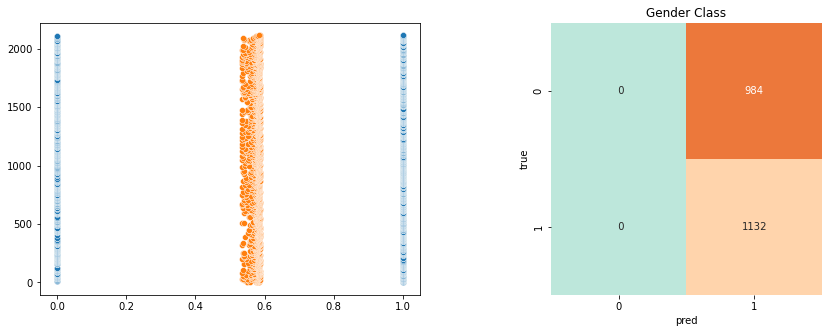

Gender Prediction Accuracy:  0.5349716446124764

CLASSIFICAITON REPORT
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       984
         1.0       0.53      1.00      0.70      1132

    accuracy                           0.53      2116
   macro avg       0.27      0.50      0.35      2116
weighted avg       0.29      0.53      0.37      2116



In [112]:
Pgender = Pgender.reshape(len(Pgender))
Tgender = Tgender.reshape(len(Tgender))
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.scatterplot(y=np.arange(len(Pgender)),x=Tgender)
sns.scatterplot(y=np.arange(len(Pgender)),x=Pgender)
confMat = metrics.confusion_matrix(Tgender,Pgender>=0.5)
plt.subplot(1,2,2)
sns.heatmap(confMat,annot=confMat,fmt="3d",cmap='icefire',cbar=False,square=True)
plt.xlabel("pred")
plt.ylabel("true")
plt.title("Gender Class")
plt.show()
print("Gender Prediction Accuracy: ",metrics.accuracy_score(Tgender,Pgender>0.5))
print("\nCLASSIFICAITON REPORT")
print(metrics.classification_report(Tgender,Pgender>0.5,zero_division=0))

eventually the model has predicted all the datapoints to 1 (male), with ZERO recall for 0 class (female)

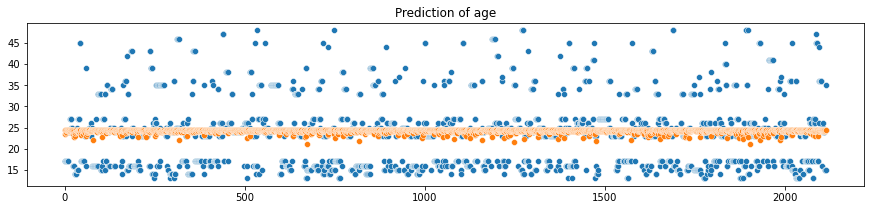

Age prediction error:  5.891081088882763


In [113]:
Tage = (Tage*(pp.maAge-pp.miAge)+pp.miAge).reshape(len(Tage))
Page = (Page*(pp.maAge-pp.miAge)+pp.miAge).reshape(len(Page))
plt.figure(figsize=(15,3))
sns.scatterplot(x=np.arange(len(Page)),y=Tage)
sns.scatterplot(x=np.arange(len(Page)),y=Page)
plt.title("Prediction of age")
plt.show()
print("Age prediction error: ",metrics.mean_absolute_error(Tage,Page))

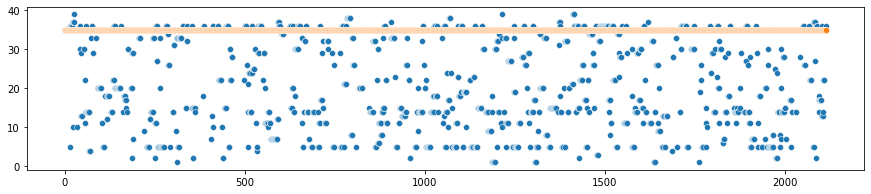

Topic Prediction accuracy 0.3771266540642722


In [114]:
p_topic=np.empty_like(Ptopic)
for i,t in enumerate(Ptopic):
    tmp = np.zeros_like(t)
    tmp[t.argmax()]=1
    p_topic[i] = tmp
tt = [t.argmax() for t in Ttopic]
pt = [t.argmax() for t in Ptopic]
plt.figure(figsize=(15,3))
sns.scatterplot(x=np.arange(len(tt)),y=tt)
sns.scatterplot(x=np.arange(len(tt)),y=pt)
plt.show()
print("Topic Prediction accuracy",metrics.accuracy_score(Ttopic,p_topic))

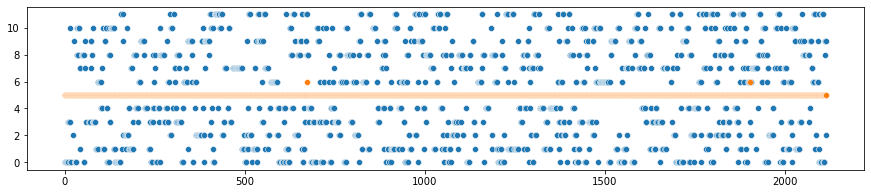

              precision    recall  f1-score   support

       Aries       0.00      0.00      0.00       224
      Taurus       0.00      0.00      0.00       189
      Gemini       0.00      0.00      0.00       160
      Cancer       0.00      0.00      0.00       177
         Leo       0.00      0.00      0.00       183
       Virgo       0.10      1.00      0.19       220
       Libra       0.00      0.00      0.00       187
     Scorpio       0.00      0.00      0.00       163
 Sagittarius       0.00      0.00      0.00       179
   Capricorn       0.00      0.00      0.00       155
    Aquarius       0.00      0.00      0.00       136
      Pisces       0.00      0.00      0.00       143

    accuracy                           0.10      2116
   macro avg       0.01      0.08      0.02      2116
weighted avg       0.01      0.10      0.02      2116



In [115]:
Tsign = (Tsign*len(pp.s2id)).reshape(len(Tsign))
Psign = (Psign*len(pp.s2id)).reshape(len(Psign)).astype(int)
plt.figure(figsize=(15,3))
sns.scatterplot(x=np.arange(len(Tsign)),y=Tsign)
sns.scatterplot(x=np.arange(len(Tsign)),y=Psign)
plt.show()
print(metrics.classification_report(Tsign,Psign,zero_division=0,target_names=list(pp.s2id.keys())))

Thats definitely a NO-GO model<br>
building a ML model

In [21]:
# prerequisites
sWords = stopwords.words('english') + list(punctuation)
lemma = WordNetLemmatizer().lemmatize

lemmaPOS = {p:'v' for p in ['VB','VBD','VBG','VBN','VBP','VBZ']}
lemmaPOS.update({p:'a' for p in ['JJ','JJR','JJS']})
lemmaPOS.update({p:'r' for p in ['RB','RBR','RBS']})
        
def wordy(doc):
    """parse & process each document"""
    
    # convert all html escape characters
    doc = html.unescape(doc)
    
    # demojize:convert emojies to word expressions & return 
    doc = emoji.demojize(doc,delimiters=(" "," "))
    
    # convert numbers to words
    for match in re.findall(r'([0-9]+[\.]{0,1}[0-9])|([0-9])',doc):
        match = np.sort(np.array(match))[-1]
        doc = re.sub(match,' '+num2words(match)+' ',doc)
        
    # remove any remaining non-alphabets
    doc = re.sub(r'[^a-zA-Z\s]','',doc)
    
    # tokenize
    # POS tagging
    wordTags = pos_tag(word_tokenize(doc))
    
    # ignore stop words
    # cast to lowercase
    # lemmatize
    words = np.array([lemma(word.lower(),lemmaPOS.get(tag,'n')) 
                         for (word,tag) in wordTags if word.lower() not in sWords])
    
    return words

In [22]:
def prepare(df):
    df = df.copy()
    
    # strip all spaces on either edges of the text field
    tqdm.pandas(desc="strip")
    df["text"] = df["text"].progress_apply(lambda x: x.strip())
    
    # demojize,num2words,strip-non-alphabets,tokenize
    textArray = df.text.values
    df["words"] = Parallel(n_jobs=-1,verbose=0)(delayed(wordy)(doc) for doc in tqdm(textArray,desc="wordy"))
    
    # drop records whose words were only stop words
    tqdm.pandas(desc="empties deletion")
    df.drop(df.loc[df.words.progress_apply(lambda x: len(x))==0].index,inplace=True)
    
    # rejoin sentences
    tqdm.pandas(desc="rejoinSentences")
    df["sents"] = df.words.progress_apply(lambda x: ' '.join(x))
    
    # age as string
    tqdm.pandas(desc="num2str")
    df["age"] = df.age.progress_apply(lambda x: str(x))
    
    return df[["words","sents","gender","age","topic","sign"]]

In [23]:
# modified preprocessing suitable for ML
dtrain1 = prepare(dTrain)
dtest1 = prepare(dTest)

num2str: 100%|████████████████████████████| 996/996 [00:00<00:00, 385665.32it/s]


In [24]:
# independent Features
Xtrain1 = dtrain1["sents"]
Xtest1 = dtest1["sents"]

In [25]:
# Target CLasses
Ytrain = dtrain1[["gender","age","topic","sign"]].values
Ytest = dtest1[["gender","age","topic","sign"]].values

In [26]:
# list of all possible labels (based on train data)
globalLabels = np.array([]) #"0_not_in_here"
globalLabels = np.append(globalLabels,dtrain1.gender.unique())
globalLabels = np.append(globalLabels,dtrain1.age.unique())
globalLabels = np.append(globalLabels,dtrain1.topic.unique())
globalLabels = np.append(globalLabels,dtrain1.sign.unique())
print(sorted(globalLabels))
print(len(globalLabels))

['13', '14', '15', '16', '17', '23', '24', '25', '26', '27', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', 'Accounting', 'Advertising', 'Agriculture', 'Aquarius', 'Architecture', 'Aries', 'Arts', 'Automotive', 'Banking', 'Biotech', 'BusinessServices', 'Cancer', 'Capricorn', 'Chemicals', 'Communications-Media', 'Construction', 'Consulting', 'Education', 'Engineering', 'Environment', 'Fashion', 'Gemini', 'Government', 'HumanResources', 'Internet', 'InvestmentBanking', 'Law', 'LawEnforcement-Security', 'Leo', 'Libra', 'Manufacturing', 'Maritime', 'Marketing', 'Military', 'Museums-Libraries', 'Non-Profit', 'Pisces', 'Publishing', 'RealEstate', 'Religion', 'Sagittarius', 'Science', 'Scorpio', 'Sports-Recreation', 'Student', 'Taurus', 'Technology', 'Telecommunications', 'Tourism', 'Transportation', 'Virgo', 'female', 'male']
79


In [27]:
# Target classes encoding
from sklearn.preprocessing import MultiLabelBinarizer
mlbin = MultiLabelBinarizer(classes=sorted(globalLabels))
YtrainML = mlbin.fit_transform(Ytrain)
YtestML = mlbin.transform(Ytest)

In [28]:
# review support for classes
supportV = dict(zip(mlbin.classes,np.sum(YtrainML,axis=0)))
supportC = dict(zip(np.sum(YtrainML,axis=0),mlbin.classes))
Lindex = dict(zip(mlbin.classes,range(80)))
print("index  __ class               :support")
display(["(%02d) __ %-20s:%d"%(Lindex[j],j,supportV[j]) for j in [supportC[i] for i in sorted(supportC)]])

index  __ class               :support


['(57) __ Maritime            :3',
 '(45) __ Environment         :15',
 '(41) __ Construction        :28',
 '(25) __ 48                  :29',
 '(19) __ 42                  :30',
 '(33) __ Automotive          :31',
 '(51) __ InvestmentBanking   :34',
 '(28) __ Agriculture         :35',
 '(30) __ Architecture        :37',
 '(74) __ Tourism             :40',
 '(18) __ 41                  :47',
 '(75) __ Transportation      :50',
 '(23) __ 46                  :55',
 '(56) __ Manufacturing       :57',
 '(16) __ 39                  :60',
 '(15) __ 38                  :61',
 '(64) __ RealEstate          :63',
 '(35) __ Biotech             :67',
 '(59) __ Military            :68',
 '(34) __ Banking             :76',
 '(69) __ Sports-Recreation   :77',
 '(60) __ Museums-Libraries   :80',
 '(22) __ 45                  :85',
 '(73) __ Telecommunications  :87',
 '(36) __ BusinessServices    :96',
 '(58) __ Marketing           :102',
 '(26) __ Accounting          :103',
 '(27) __ Advertising      

pretty imbalanced dataset

In [29]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

In [30]:
# bag of words
vectorizerCV = CountVectorizer(ngram_range=(1,4))
XtrainCV = vectorizerCV.fit_transform(Xtrain1)
XtestCV = vectorizerCV.transform(Xtest1)

In [31]:
# print the shape of the sparse vector
XtrainCV[0].get_shape()

(1, 2809012)

In [32]:
# tfidf
vectorizerT = TfidfVectorizer(ngram_range=(1,4))
XtrainT = vectorizerT.fit_transform(Xtrain1)
XtestT = vectorizerT.transform(Xtest1)

In [33]:
# print the shape of the sparse vector
XtrainT[0].get_shape()

(1, 2809012)

In [34]:
# Hashing
vectorizerH = HashingVectorizer(ngram_range=(1,4))
XtrainH = vectorizerH.fit_transform(Xtrain1)
XtestH = vectorizerH.transform(Xtest1)

In [35]:
# print the shape of the sparse vector
XtrainH[0].get_shape()

(1, 1048576)

In [34]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [35]:
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, recall_score

In [36]:
def scores(yt,pred):
    print("accuracy_score:",accuracy_score(yt,pred))
    print("f1_score:",f1_score(yt,pred,average='macro'))
    print("recall_score:",recall_score(yt,pred,average='macro'))
    print("average_precision_score:",average_precision_score(yt,pred,average='macro'))

In [37]:
def fit_n_result(clf,Xt,Yt,Xv,Yv):
    clf.fit(Xt,Yt)
    print("TRAINING metrics:"),scores(Yt,clf.predict(Xt))
    print("TESTING metrics:"),scores(Yv,clf.predict(Xv))
    return clf

In [38]:
import warnings
warnings.filterwarnings("ignore")

In [39]:
lrCLF = OneVsRestClassifier(LogisticRegression(solver='saga',multi_class='ovr'))#,n_jobs=-1)
svCLF = OneVsRestClassifier(LinearSVC(loss='hinge',multi_class='ovr'),n_jobs=-1)

In [46]:
%%time
print("OVR_LogReg_Count")
clf1 = fit_n_result(lrCLF,XtrainCV[:1000],YtrainML[:1000],XtestCV,YtestML)
# further reduction in size due to inability to run njobs=-1 for large dataset
print("="*100,"\n\n")

OVR_LogReg_Count
TRAINING metrics:
accuracy_score: 0.022
f1_score: 0.08358224132462938
recall_score: 0.06058025041568634
average_precision_score: nan
TESTING metrics:
accuracy_score: 0.0
f1_score: 0.019840230880132124
recall_score: 0.018499171876259757
average_precision_score: nan


CPU times: user 5min 6s, sys: 152 ms, total: 5min 6s
Wall time: 5min 6s


In [54]:
%%time
print("OVR_LinSVC_Count")
clf2 = fit_n_result(svCLF,XtrainCV,YtrainML,XtestCV,YtestML)
print("="*100,"\n\n")

OVR_LinSVC_Count
TRAINING metrics:
accuracy_score: 0.9911611088790679
f1_score: 0.9961895191865643
recall_score: 0.9925573264229101
average_precision_score: 0.9927504278000829
TESTING metrics:
accuracy_score: 0.0050200803212851405
f1_score: 0.054900944793260124
recall_score: 0.04446612807784258
average_precision_score: nan


CPU times: user 6.7 s, sys: 1.66 s, total: 8.36 s
Wall time: 4min 33s


In [55]:
%%time
print("OVR_LogReg_TFIDF")
clf3 = fit_n_result(lrCLF,XtrainT[:2000],YtrainML[:2000],XtestT,YtestML)
# reduction in size due to inability to run njobs=-1 for large dataset
print("="*100,"\n\n")

OVR_LogReg_TFIDF


/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/sit

/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/sit

TRAINING metrics:
accuracy_score: 0.0
f1_score: 0.031886078245623714
recall_score: 0.02969748393911583
average_precision_score: 0.06587164369468108
TESTING metrics:
accuracy_score: 0.0
f1_score: 0.015553942888094717
recall_score: 0.015656501029745664
average_precision_score: nan


CPU times: user 4.36 s, sys: 1.49 s, total: 5.85 s
Wall time: 3min 32s


In [56]:
%%time
print("OVR_LinSVC_TFIDF")
clf4 = fit_n_result(svCLF,XtrainT,YtrainML,XtestT,YtestML)
print("="*100,"\n\n")

OVR_LinSVC_TFIDF


/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


TRAINING metrics:
accuracy_score: 0.6519686621132985
f1_score: 0.6373600772918615
recall_score: 0.5379893450880187
average_precision_score: 0.5437999811758442
TESTING metrics:
accuracy_score: 0.0030120481927710845
f1_score: 0.02784077902017758
recall_score: 0.024536872414015313
average_precision_score: nan


CPU times: user 6.24 s, sys: 1.67 s, total: 7.91 s
Wall time: 4min 49s


In [57]:
%%time
print("OVR_LogReg_Hash")
clf5 = fit_n_result(lrCLF,XtrainH[:2000],YtrainML[:2000],XtestH,YtestML)
# reduction in size due to inability to run njobs=-1 for large dataset
print("="*100,"\n\n")

OVR_LogReg_Hash


/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/sit

/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/sit

TRAINING metrics:
accuracy_score: 0.0
f1_score: 0.03013404430225084
recall_score: 0.027734360403597787
average_precision_score: 0.06284344823920625
TESTING metrics:
accuracy_score: 0.0
f1_score: 0.017102678035095967
recall_score: 0.016613702067346088
average_precision_score: nan


CPU times: user 2.79 s, sys: 438 ms, total: 3.23 s
Wall time: 5min 11s


In [58]:
%%time
print("OVR_LinSVC_Hash")
clf6 = fit_n_result(svCLF,XtrainH,YtrainML,XtestH,YtestML)
print("="*100,"\n\n")

OVR_LinSVC_Hash


/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


TRAINING metrics:
accuracy_score: 0.04128163921253516
f1_score: 0.16808000503602394
recall_score: 0.11295456380278213
average_precision_score: 0.14172118252369215
TESTING metrics:
accuracy_score: 0.0
f1_score: 0.022975622504354438
recall_score: 0.020713752258785103
average_precision_score: nan


CPU times: user 4.58 s, sys: 451 ms, total: 5.03 s
Wall time: 4min 5s


the ***LinearSVC*** based classifier using ***CountVector*** has performed the best among the above 6<br>
producing top accuracy_score of **only 0.005** on Testing data<br><br>
the LogisticRegression models couldn't consume the complete dataset in the given machine, thus also resulting in reduced prediction performance.<br>

though not a significant score, let us further hypertune the LinearSVC models

In [41]:
pGrid = [dict(loss='hinge',multi_class='ovr',penalty='l2',C=1)]
pGrid.append(dict(loss='hinge',multi_class='ovr',penalty='l2',C=0.1))
pGrid.append(dict(loss='hinge',multi_class='ovr',penalty='l2',C=10))
pGrid.append(dict(loss='squared_hinge',multi_class='ovr',penalty='l1',C=1,dual=False))
pGrid.append(dict(loss='squared_hinge',multi_class='ovr',penalty='l1',C=0.1,dual=False))
pGrid.append(dict(loss='squared_hinge',multi_class='ovr',penalty='l1',C=10,dual=False))
pGrid

[{'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l2', 'C': 1},
 {'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l2', 'C': 0.1},
 {'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l2', 'C': 10},
 {'loss': 'squared_hinge',
  'multi_class': 'ovr',
  'penalty': 'l1',
  'C': 1,
  'dual': False},
 {'loss': 'squared_hinge',
  'multi_class': 'ovr',
  'penalty': 'l1',
  'C': 0.1,
  'dual': False},
 {'loss': 'squared_hinge',
  'multi_class': 'ovr',
  'penalty': 'l1',
  'C': 10,
  'dual': False}]

In [60]:
svTune = []
for gp in pGrid:
    clf = OneVsRestClassifier(LinearSVC(**gp),n_jobs=1)
    print(gp)
    clf = fit_n_result(clf,XtrainCV[:2000],YtrainML[:2000],XtestCV,YtestML) #less data for tuning
    print("="*100,"\n\n")
    svTune.append(clf)    

{'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l2', 'C': 1}
TRAINING metrics:
accuracy_score: 0.995
f1_score: 0.9975692531126571
recall_score: 0.9952707503973104
average_precision_score: 0.9954432007240278
TESTING metrics:
accuracy_score: 0.0030120481927710845
f1_score: 0.03910166100980534
recall_score: 0.032710175138276856
average_precision_score: nan


{'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l2', 'C': 0.1}
TRAINING metrics:
accuracy_score: 0.954
f1_score: 0.9786988919351561
recall_score: 0.9596758520369555
average_precision_score: 0.9612076619991451
TESTING metrics:
accuracy_score: 0.0
f1_score: 0.02863124469035602
recall_score: 0.024350138260404275
average_precision_score: nan


{'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l2', 'C': 10}
TRAINING metrics:
accuracy_score: 0.9975
f1_score: 0.9982948791901334
recall_score: 0.9966856113254221
average_precision_score: 0.9967757831711272
TESTING metrics:
accuracy_score: 0.004016064257028112
f1_score: 0.0394267244488

In [42]:
def resPlot(yt,pred):
    y = [accuracy_score(yt,pred)]
    y.append(f1_score(yt,pred,average='macro'))
    y.append(recall_score(yt,pred,average='macro'))
    y.append(average_precision_score(yt,pred,average='macro'))
    x = ['accuracy','F1','recall','precision']
    ax = sns.barplot(x,y)
    plt.ylim(0.0,0.075)
    return ax

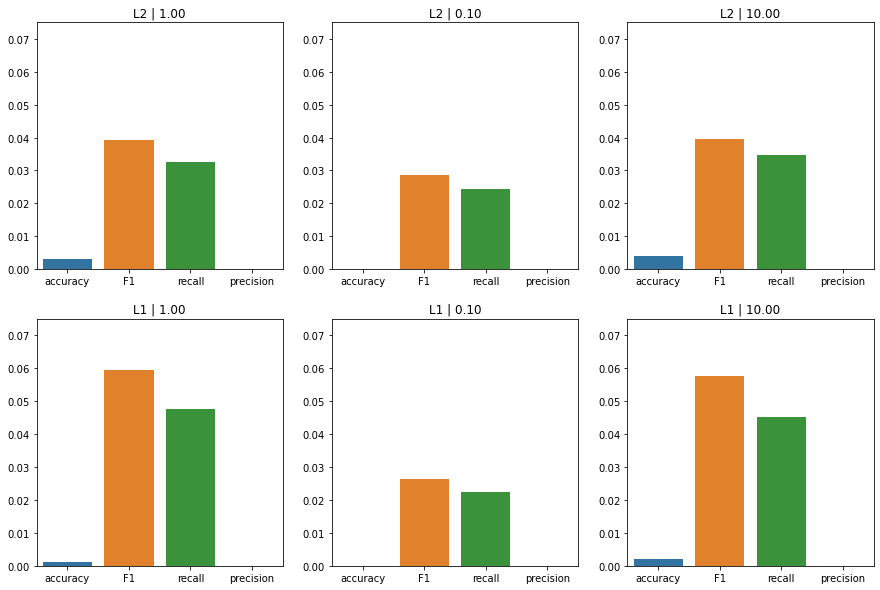

In [62]:
plt.figure(figsize=(15,10))
for i,clf in enumerate(svTune):
    plt.subplot(2,3,i+1)    
    resPlot(YtestML,svTune[i].predict(XtestCV))
    plt.title("%s | %02.2f"%(pGrid[i].get('penalty').upper(),pGrid[i].get('C')))
plt.show()

the second & fifth hyper parameters have resulted in scores less than 0.95, lets ignore them<br>
based on the comparison,<br>
the best accurate model will be third model with<br>

penalty **L2**, **hinge** loss and **10** C<br>

scores:<br>
accuracy_score: 0.004016064257028112<br>
f1_score: 0.03942672444883629<br>
recall_score: 0.03459491827044439<br>

on the other hand the sith model with penalty **L1**, **squared_hinge** loss and **10** C<br>
showcases the highest F1 score, indicating least FP & FN values<br>
accuracy_score: 0.002008032128514056<br>
f1_score: 0.05759224018597131<br>
recall_score: 0.04531022082927411<br>

hopefully at full data, the models might learn better<br>

lets also attempt hypertuning the **TFIDF** based models also using **LinearSVC**

In [44]:
svTFIDFtune=[]
for gp in pGrid:
    clf = OneVsRestClassifier(LinearSVC(**gp),n_jobs=-1)
    print(gp)
    clf = fit_n_result(clf,XtrainT[:2000],YtrainML[:2000],XtestT,YtestML)
    print("="*100,"\n\n")
    svTFIDFtune.append(clf)  

{'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l2', 'C': 1}
TRAINING metrics:
accuracy_score: 0.82
f1_score: 0.7315998697584591
recall_score: 0.6566829971389825
average_precision_score: 0.6594124094910165
TESTING metrics:
accuracy_score: 0.0
f1_score: 0.020799721328937044
recall_score: 0.01926692207979162
average_precision_score: nan


{'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l2', 'C': 0.1}
TRAINING metrics:
accuracy_score: 0.0
f1_score: 0.009191324679513021
recall_score: 0.012658227848101266
average_precision_score: 0.050632911392405076
TESTING metrics:
accuracy_score: 0.0
f1_score: 0.00895358102169395
recall_score: 0.012658227848101266
average_precision_score: nan


{'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l2', 'C': 10}
TRAINING metrics:
accuracy_score: 0.9975
f1_score: 0.9982948791901334
recall_score: 0.9966856113254221
average_precision_score: 0.9967757831711272
TESTING metrics:
accuracy_score: 0.001004016064257028
f1_score: 0.023383949335463824
recall_sc

/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.p

TRAINING metrics:
accuracy_score: 0.9915
f1_score: 0.9924540615326842
recall_score: 0.9856350271563027
average_precision_score: 0.9858201357108684
TESTING metrics:
accuracy_score: 0.0030120481927710845
f1_score: 0.06856583554029494
recall_score: 0.0564412548898079
average_precision_score: nan




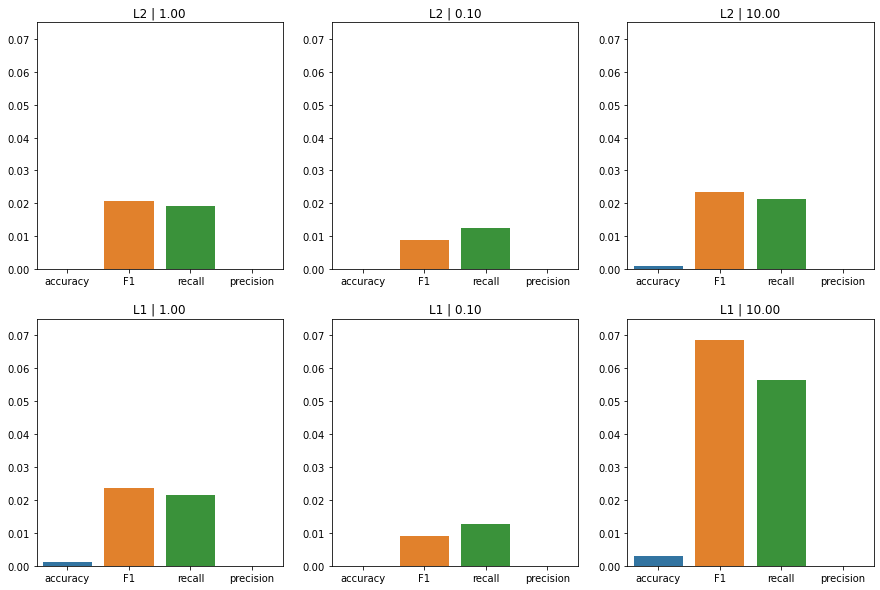

In [47]:
plt.figure(figsize=(15,10))
for i,clf in enumerate(svTFIDFtune):
    plt.subplot(2,3,i+1)    
    resPlot(YtestML,clf.predict(XtestT))
    plt.title("%s | %02.2f"%(pGrid[i].get('penalty').upper(),pGrid[i].get('C')))
plt.show()

ignoring the underperforming ones,<br>
based on the comparison,<br>
the best model will **again** be sixth one with<br>

penalty **L1**, **squared_hinge** loss and **10** C<br>

with better scores:<br>
accuracy_score: 0.0030120481927710845<br>
f1_score: 0.06856583554029494<br>
recall_score: 0.0564412548898079<br>

this one is more promising than the model 3 or 6 of CountVector basis, owing the better F1 scores

* considering more significance to reducing false predictions, F1 score shall be considered as a joint representation for lesser FP & FN predictions

lets train the model with complete data

In [43]:
gp = pGrid[5]
clf = OneVsRestClassifier(LinearSVC(**gp),n_jobs=-1)
clf = fit_n_result(clf,XtrainT,YtrainML,XtestT,YtestML)

/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.p

TRAINING metrics:
accuracy_score: 0.9872438730413821
f1_score: 0.9916547512442079
recall_score: 0.9837831847044703
average_precision_score: 0.9839745714074939
TESTING metrics:
accuracy_score: 0.008032128514056224
f1_score: 0.1349805338027878
recall_score: 0.12193126509657523
average_precision_score: nan


In [44]:
gp = pGrid[5]
gp.update(dict(C=50))
clf50 = OneVsRestClassifier(LinearSVC(**gp),n_jobs=-1)
clf50 = fit_n_result(clf50,XtrainT,YtrainML,XtestT,YtestML)

/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.p

/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/harinaathan/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.p

TRAINING metrics:
accuracy_score: 0.9940739252711932
f1_score: 0.9976562350622825
recall_score: 0.9954702338896143
average_precision_score: 0.9955453787045393
TESTING metrics:
accuracy_score: 0.007028112449799197
f1_score: 0.1343035871951517
recall_score: 0.12338318046878068
average_precision_score: nan


**Explanations**<br>
the **LinearSVC** out performs LogisticRegression owing to the capabilities of hyperplaning and perceiving the separability of the datapoint using kernels<br>
the **TFIDF** vector supports better classification as it inherently relates each word with the entire corpus rather than just one hot encoding the words<br>
the **L1** penalty helps eliminating features of low importance and thus reduces the noise being learnt. This helps the model to better generalize<br>
the **C=10** regularisation for SVC insists in lesser margin for the hyperplane, thus reuding misclassification

yet, given the variability of independant features and the possible curse of dimensionality, combined with the constraints of the computations & memory, these models are producing substandard results

In [45]:
# classification report
print(metrics.classification_report(YtestML,clf.predict(XtestT),target_names=mlbin.classes,digits=3))

                         precision    recall  f1-score   support

                     13      0.000     0.000     0.000        21
                     14      0.300     0.188     0.231        48
                     15      0.181     0.203     0.191        64
                     16      0.303     0.312     0.307       138
                     17      0.218     0.324     0.261       111
                     23      0.208     0.240     0.223       104
                     24      0.189     0.198     0.194       106
                     25      0.133     0.184     0.155        98
                     26      0.133     0.139     0.136        79
                     27      0.159     0.127     0.141        55
                     33      0.278     0.217     0.244        23
                     34      0.300     0.150     0.200        20
                     35      0.300     0.115     0.167        26
                     36      0.250     0.069     0.108        29
                     37 

the model has classified the authorship to a certain extent<br>
the macro average scores indicate roughly only 12~18 percent of the predictions will be true

In [47]:
# display true & predicted authorship for 5 random datapoints
np.random.seed(129)
i = np.random.choice(range(dTrain.shape[0]),5,False)
dRandom = df.iloc[i].copy()
dRandom2 = prepare(dRandom)
Xprod = dRandom2["sents"]
Xprod = vectorizerT.transform(Xprod)
Yprod = dRandom2[["gender","age","topic","sign"]].values
pred = clf.predict(Xprod)
pred = mlbin.inverse_transform(pred)

num2str: 100%|██████████████████████████████████| 5/5 [00:00<00:00, 8035.07it/s]


In [48]:
for doc in zip(dRandom["text"],Yprod,pred):
    print('\033[1m'+'TEXT'+'\033[0m')
    print(doc[0])
    print('\nTRUE Authorship:'+'\033[1m'+str(doc[1])+'\033[0m')
    print('PREDICTED Authorship:'+'\033[1m'+str(doc[2])+'\033[0m')
    print("="*100,"\n\n")

TEXT
       That's right, this is the week, Jen arrives on Thursday and will be staying right through to the following Sunday - Yay! :)  Also on the good news front, I now have Cable TV, Broadband and a new mattress.  On the not-so-good-news-for-Jenny front I still don't have a bed frame, a couch, or even something besides the floor for her to sit on......  On the other hand that does mean that she will have plenty of reasons to do that favourite female pastime - shopping! And with someone else's money no less - always the best way to do it.  Should be getting a few rack mounted dual PIII's gratis from the job too - will be nice to play with them, maybe set up a beowulf cluster or something else equally difficult to configure :)  After all I'll need something to do with my spare time when Jen leaves :)         

TRUE Authorship:['male' '25' 'Internet' 'Aries']
PREDICTED Authorship:('23', '24', 'Libra', 'female')


TEXT
           ...or something like that.  I'm in the middle of the big

## Part TWO

**DOMAIN:** Customer support<br>
**• CONTEXT:** Great Learning has a an academic support department which receives numerous support requests every day throughout the year. Teams are spread across geographies and try to provide support round the year. Sometimes there are circumstances where due to heavy workload certain request resolutions are delayed, impacting company’s business. Some of the requests are very generic where a proper resolution procedure delivered to the user can solve the problem. Company is looking forward to design an automation which can interact with the user, understand the problem and display the resolution procedure [ if found as a generic request ] or redirect the request to an actual human support executive if the request is complex or not in it’s database.<br>
**• DATA DESCRIPTION:** A sample corpus is attached for your reference. Please enhance/add more data to the corpus using your linguistics skills.<br>
**• PROJECT OBJECTIVE:** Design a python based interactive semi - rule based chatbot which can do the following:<br>
1. Start chat session with greetings and ask what the user is looking for.
2. Accept dynamic text based questions from the user. Reply back with relevant answer from the designed corpus.
3. End the chat session only if the user requests to end else ask what the user is looking for. Loop continues till the user asks to end it.

In [24]:
import re, emoji, nltk, html
from num2words import num2words
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag 
from string import punctuation
import json
import numpy as np
import pandas as pd
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [25]:
# read sample corpus
file = open('GL Bot.json').read()
data = json.loads(file)

In [26]:
# review the sample data
data.keys()

dict_keys(['intents'])

In [27]:
len(data['intents'])

8

In [28]:
for i in range(len(data['intents'])):
    display(data['intents'][i].keys())

dict_keys(['tag', 'patterns', 'responses', 'context_set'])

dict_keys(['tag', 'patterns', 'responses', 'context_set'])

dict_keys(['tag', 'patterns', 'responses', 'context_set'])

dict_keys(['tag', 'patterns', 'responses', 'context_set'])

dict_keys(['tag', 'patterns', 'responses', 'context_set'])

dict_keys(['tag', 'patterns', 'responses', 'context_set'])

dict_keys(['tag', 'patterns', 'responses', 'context_set'])

dict_keys(['tag', 'patterns', 'responses', 'context_set'])

In [29]:
intents = data['intents']

In [30]:
for i in range(len(intents)):
    doc = intents[i]
    print("TAG:",doc['tag'])
    print("RESPONSE:",doc['responses'])
    print("CONTEXT:",doc['context_set'])
    print("="*100,"\n")

TAG: Intro
RESPONSE: ['Hello! how can i help you ?']
CONTEXT: 

TAG: Exit
RESPONSE: ['I hope I was able to assist you, Good Bye']
CONTEXT: 

TAG: Olympus
RESPONSE: ['Link: Olympus wiki']
CONTEXT: 

TAG: SL
RESPONSE: ['Link: Machine Learning wiki ']
CONTEXT: 

TAG: NN
RESPONSE: ['Link: Neural Nets wiki']
CONTEXT: 

TAG: Bot
RESPONSE: ['I am your virtual learning assistant']
CONTEXT: 

TAG: Profane
RESPONSE: ['Please use respectful words']
CONTEXT: 

TAG: Ticket
RESPONSE: ['Tarnsferring the request to your PM']
CONTEXT: 



lets us create a dataset for training the cat bot using the patterns as the independent feature and the tag as the target class of query, which will yield a resultant response

In [31]:
# import additional queries added manually
xtra = pd.read_excel("bot_additional_questions.xlsx")

In [32]:
# output response for each class of query
tags = [intents[i]["tag"] for i in range(len(intents))]
tags.extend([w for w in list(xtra.tag.unique()) if w not in tags])
t2id = dict(zip(tags,range(len(tags))))
id2t = dict(zip(range(len(tags)),tags))

responses = [intents[i]["responses"][0] for i in range(len(intents))]
responses.extend([resp 
                  for resp in list(xtra.responses.unique()) 
                  if resp not in responses])

tag2response = dict(zip(tags,responses))
tag2response

{'Intro': 'Hello! how can i help you ?',
 'Exit': 'I hope I was able to assist you, Good Bye',
 'Olympus': 'Link: Olympus wiki',
 'SL': 'Link: Machine Learning wiki ',
 'NN': 'Link: Neural Nets wiki',
 'Bot': 'I am your virtual learning assistant',
 'Profane': 'Please use respectful words',
 'Ticket': 'Tarnsferring the request to your PM',
 'ML': 'Link: Machine Learning Wiki'}

In [33]:
# prerequisites
sWords = stopwords.words('english') + list(punctuation)
lemma = WordNetLemmatizer().lemmatize

lemmaPOS = {p:'v' for p in ['VB','VBD','VBG','VBN','VBP','VBZ']}
lemmaPOS.update({p:'a' for p in ['JJ','JJR','JJS']})
lemmaPOS.update({p:'r' for p in ['RB','RBR','RBS']})
        
def wordy(doc):
    """parse & process each document"""
    
    # convert all html escape characters
    doc = html.unescape(doc)
    
    # demojize:convert emojies to word expressions & return 
    doc = emoji.demojize(doc,delimiters=(" "," "))
    
    # convert numbers to words
    for match in re.findall(r'([0-9]+[\.]{0,1}[0-9])|([0-9])',doc):
        match = np.sort(np.array(match))[-1]
        doc = re.sub(match,' '+num2words(match)+' ',doc)
        
    # remove any remaining non-alphabets
    doc = re.sub(r'[^a-zA-Z\s]','',doc)
    
    # tokenize
    # POS tagging
    wordTags = pos_tag(word_tokenize(doc))
    
    # ignore stop words
    # cast to lowercase
    # lemmatize
    words = np.array([lemma(word.lower(),lemmaPOS.get(tag,'n')) for (word,tag) in wordTags])
    
    return ' '.join(words)

In [34]:
# test
wordy(intents[0]["patterns"][-1])

'talk to you for first time'

In [35]:
X = []
Y = []
# from json
for intent in intents:
    for doc in intent["patterns"]:
        X.append(wordy(doc))
        tmp = np.zeros(len(tags))
        tmp[t2id[intent["tag"]]]=1
        Y.append(tmp)
        
# from custom excel
for row in xtra.values:
    X.append(wordy(row[0]))
    tmp = np.zeros(len(tags))
    tmp[t2id[row[1]]]=1
    Y.append(tmp)

In [36]:
# review training data length
len(X),len(Y)

(204, 204)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=129)

In [38]:
# tfidf
vectorizerT = TfidfVectorizer(ngram_range=(1,4))
X_train = vectorizerT.fit_transform(X_train)
X_test = vectorizerT.transform(X_test)

In [39]:
# review independent feature size
X_train.get_shape()

(183, 1274)

Lets train a classifier to identify the nature & subject of the query

In [40]:
def fit_n_result(clf,Xt,Yt,Xv,Yv):
    clf.fit(Xt,Yt)
    pred = clf.predict(Xt)
    a = "%.3f"%(accuracy_score(Yt,pred))
    f = "%.3f"%(f1_score(Yt,pred,average='macro'))
    r = "%.3f"%(recall_score(Yt,pred,average='macro'))
    p = "%.3f"%(average_precision_score(Yt,pred,average='macro'))
    print("%31s %12s %12s %12s"%("Accuracy","F1","Recall","Precision"))
    print("%-18s %12s %12s %12s %12s"%("TRAINING metrics:",a,f,r,p))
    pred = clf.predict(Xv)
    a = "%.3f"%(accuracy_score(Yv,pred))
    f = "%.3f"%(f1_score(Yv,pred,average='macro'))
    r = "%.3f"%(recall_score(Yv,pred,average='macro'))
    p = "%.3f"%(average_precision_score(Yv,pred,average='macro'))
    print("%-18s %12s %12s %12s %12s"%("TESTING metrics:",a,f,r,p))
    return clf

In [41]:
pGrid = [dict(loss='hinge',multi_class='ovr',penalty='l2',C=1)]
pGrid.append(dict(loss='hinge',multi_class='ovr',penalty='l2',C=0.1))
pGrid.append(dict(loss='hinge',multi_class='ovr',penalty='l2',C=10))
pGrid.append(dict(loss='squared_hinge',multi_class='ovr',penalty='l1',C=1,dual=False))
pGrid.append(dict(loss='squared_hinge',multi_class='ovr',penalty='l1',C=0.1,dual=False))
pGrid.append(dict(loss='squared_hinge',multi_class='ovr',penalty='l1',C=10,dual=False))

In [42]:
svTune = []
for i,gp in enumerate(pGrid):
    clf = OneVsRestClassifier(LinearSVC(max_iter=5000,**gp),n_jobs=-1)
    print("Model_%03d"%(i+1))
    print(gp,'\n')
    clf = fit_n_result(clf,X_train,y_train,X_test,y_test)
    print("="*100,"\n\n")
    svTune.append(clf) 

Model_001
{'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l2', 'C': 1} 

                       Accuracy           F1       Recall    Precision
TRAINING metrics:         0.907        0.914        0.860        0.861
TESTING metrics:          0.333        0.275        0.241          nan


Model_002
{'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l2', 'C': 0.1} 

                       Accuracy           F1       Recall    Precision
TRAINING metrics:         0.000        0.000        0.000        0.111
TESTING metrics:          0.000        0.000        0.000          nan


Model_003
{'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l2', 'C': 10} 

                       Accuracy           F1       Recall    Precision
TRAINING metrics:         1.000        1.000        1.000        1.000
TESTING metrics:          0.476        0.402        0.435          nan


Model_004
{'loss': 'squared_hinge', 'multi_class': 'ovr', 'penalty': 'l1', 'C': 1, 'dual': False} 

                     

lets use the best parameter and fit on the complete data<br>
the best parameter will be based on the best testing accuracy (Model_003)

In [43]:
gp = dict(loss='hinge',multi_class='ovr',penalty='l2',C=10,max_iter=5000)
clf = OneVsRestClassifier(LinearSVC(**gp),n_jobs=-1)
X2 = vectorizerT.fit_transform(X)
clf.fit(X2,Y);

now lets build a chatbot using this model as a backend

In [44]:
def chat():
    exit = False
    print("Hi there! I'm your CHATBOT! \nPlease feel free to question me")
    prompt='\033[1m'+"your query please: "+'\033[0m'
    time.sleep(0.5)
    while not exit:        
        userText = input(prompt)
        userText = vectorizerT.transform([wordy(userText)])
        tag = id2t[clf.predict(userText)[0].argmax()]
        response = tag2response[tag]
        display(response)
        prompt ='\033[1m'+"your response please: "+'\033[0m'
        if tag == 'Exit':
            exit = True
            print("="*25,"END","="*25)

In [45]:
# try chatting
chat()

Hi there! I'm your CHATBOT! 
Please feel free to question me
your query please: hi there


'Hello! how can i help you ?'

your response please: you name please


'I am your virtual learning assistant'

your response please: explain me about activation function


'Link: Neural Nets wiki'

your response please: explain cross validation please


'Hello! how can i help you ?'

your response please: explain cross validation


'Hello! how can i help you ?'

your response please: cross validation


'Hello! how can i help you ?'

your response please: data cleaning


'Link: Machine Learning Wiki'

your response please: what is bias


'Link: Machine Learning Wiki'

your response please: is AI harmful?


'Link: Neural Nets wiki'

your response please: how does computer visions & image recognition work


'Link: Neural Nets wiki'

your response please: understanding classification


'Link: Machine Learning wiki '

your response please: ensembles


'Link: Machine Learning wiki '

your response please: what are hyper parameters


'Link: Machine Learning wiki '

your response please: what does Great Lakes offer


'Link: Olympus wiki'

your response please: how to reach olypmus


'Hello! how can i help you ?'

your response please: n you are not answering my question


'Tarnsferring the request to your PM'

your response please: that should be helpful


'Hello! how can i help you ?'

your response please: i rewarded you


'Hello! how can i help you ?'

your response please: you dont get me


'Tarnsferring the request to your PM'

your response please: interesting!!!


'Hello! how can i help you ?'

your response please: that right.. explain regression


'Link: Machine Learning wiki '

your response please: what are hidden layers


'Link: Neural Nets wiki'

your response please: explain tensorflow


'Hello! how can i help you ?'

your response please: tensorflow


'Hello! how can i help you ?'

your response please: using tensorflow


'Hello! how can i help you ?'

your response please: no you are a waste


'Please use respectful words'

your response please: isit?


'Hello! how can i help you ?'

your response please: comprehend hyperparameters


'Link: Neural Nets wiki'

your response please: thats good


'I hope I was able to assist you, Good Bye'

========================= END =========================


the chat bot was intersteing to interact<br>
there are flaws, but could be corrected by further dataset<br>

to simplify dataset addition manually, a excel sheet was use <br>
the sample data of it shown below

In [46]:
xtra.sample(10)

,patterns,tag,responses
33,Data Analysis and Exploration,ML,Link: Machine Learning Wiki
14,Define Precision and Recall?,ML,Link: Machine Learning Wiki
46,What Is Supervised Versus Unsupervised Learning?,NN,Link: Neural Nets wiki
38,"What Is Tensorflow, and What Is It Used For?",NN,Link: Neural Nets wiki
41,"What Is Deep Learning, and How Does It Relate ...",NN,Link: Neural Nets wiki
26,Can logistic regression use for more than 2 cl...,ML,Link: Machine Learning Wiki
18,How do you make sure which Machine Learning Al...,ML,Link: Machine Learning Wiki
1,What are Different Types of Machine Learning a...,ML,Link: Machine Learning Wiki
59,What are the various Expert System components?,NN,Link: Neural Nets wiki
61,How can artificial intelligence be used to ide...,NN,Link: Neural Nets wiki
